In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_16/models/epoch_28.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_16/data/test_data.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_16/models/epoch_28.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 20))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/15 [00:00<?, ?it/s]

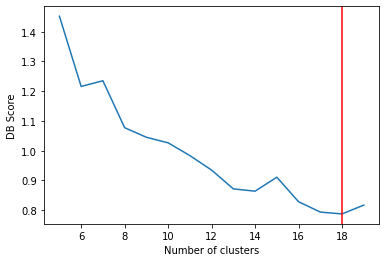

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

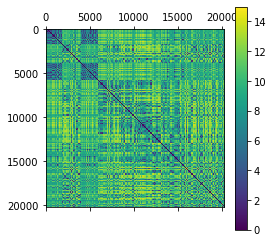

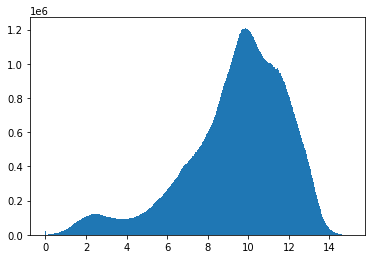

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

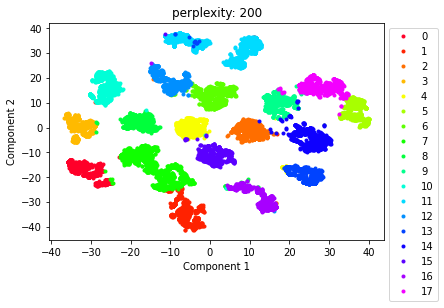

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 8

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.8934607992903957


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.46151012891344384
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.8653314917127072
layer 4: 0.8035220994475138
layer 5: 0.587189226519337
layer 6: 0.46357044198895025
Epoch: 00 | Batch: 000 / 011 | Total loss: 2.895 | Reg loss: 0.015 | Tree loss: 2.895 | Accuracy: 0.040000 | 4.928 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 2.889 | Reg loss: 0.015 | Tree loss: 2.889 | Accuracy: 0.040000 | 2.773 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 2.877 | Reg loss: 0.015 | Tree loss: 2.877 | Accuracy: 0.169000 | 2.068 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 2.869 | Reg loss: 0.015 | Tree loss: 2.869 | Accuracy: 0.194500 | 1.693 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 2.866 | Reg loss: 0.015 | Tree loss: 2.866 | Accuracy: 0.191500 | 1.437 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 2.856 | Reg loss: 0.015 | Tree loss: 2.856 | Accuracy: 0.200500 | 1.302 sec/iter
Epoch: 00 | Batch: 006 

Epoch: 05 | Batch: 000 / 011 | Total loss: 2.832 | Reg loss: 0.014 | Tree loss: 2.832 | Accuracy: 0.201000 | 0.468 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 2.816 | Reg loss: 0.014 | Tree loss: 2.816 | Accuracy: 0.206000 | 0.464 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 2.804 | Reg loss: 0.015 | Tree loss: 2.804 | Accuracy: 0.194000 | 0.462 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 2.777 | Reg loss: 0.015 | Tree loss: 2.777 | Accuracy: 0.226500 | 0.459 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 2.757 | Reg loss: 0.015 | Tree loss: 2.757 | Accuracy: 0.233000 | 0.455 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 2.730 | Reg loss: 0.015 | Tree loss: 2.730 | Accuracy: 0.270000 | 0.452 sec/iter
Epoch: 05 | Batch: 006 / 011 | Total loss: 2.722 | Reg loss: 0.015 | Tree loss: 2.722 | Accuracy: 0.262500 | 0.449 sec/iter
Epoch: 05 | Batch: 007 / 011 | Total loss: 2.704 | Reg loss: 0.016 | Tree loss: 2.704 | Accuracy: 0.268000 | 0.449 sec/iter
Epoch: 0

Epoch: 10 | Batch: 002 / 011 | Total loss: 2.635 | Reg loss: 0.018 | Tree loss: 2.635 | Accuracy: 0.275000 | 0.408 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 2.599 | Reg loss: 0.018 | Tree loss: 2.599 | Accuracy: 0.262000 | 0.409 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 2.560 | Reg loss: 0.018 | Tree loss: 2.560 | Accuracy: 0.271500 | 0.41 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 2.534 | Reg loss: 0.018 | Tree loss: 2.534 | Accuracy: 0.271000 | 0.412 sec/iter
Epoch: 10 | Batch: 006 / 011 | Total loss: 2.508 | Reg loss: 0.018 | Tree loss: 2.508 | Accuracy: 0.293500 | 0.414 sec/iter
Epoch: 10 | Batch: 007 / 011 | Total loss: 2.495 | Reg loss: 0.019 | Tree loss: 2.495 | Accuracy: 0.309000 | 0.415 sec/iter
Epoch: 10 | Batch: 008 / 011 | Total loss: 2.471 | Reg loss: 0.019 | Tree loss: 2.471 | Accuracy: 0.313500 | 0.416 sec/iter
Epoch: 10 | Batch: 009 / 011 | Total loss: 2.456 | Reg loss: 0.019 | Tree loss: 2.456 | Accuracy: 0.323000 | 0.417 sec/iter
Epoch: 10

Epoch: 15 | Batch: 004 / 011 | Total loss: 2.347 | Reg loss: 0.021 | Tree loss: 2.347 | Accuracy: 0.283500 | 0.457 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 2.311 | Reg loss: 0.021 | Tree loss: 2.311 | Accuracy: 0.292000 | 0.457 sec/iter
Epoch: 15 | Batch: 006 / 011 | Total loss: 2.264 | Reg loss: 0.021 | Tree loss: 2.264 | Accuracy: 0.282500 | 0.457 sec/iter
Epoch: 15 | Batch: 007 / 011 | Total loss: 2.262 | Reg loss: 0.021 | Tree loss: 2.262 | Accuracy: 0.281000 | 0.458 sec/iter
Epoch: 15 | Batch: 008 / 011 | Total loss: 2.225 | Reg loss: 0.021 | Tree loss: 2.225 | Accuracy: 0.307000 | 0.457 sec/iter
Epoch: 15 | Batch: 009 / 011 | Total loss: 2.211 | Reg loss: 0.022 | Tree loss: 2.211 | Accuracy: 0.306000 | 0.458 sec/iter
Epoch: 15 | Batch: 010 / 011 | Total loss: 2.191 | Reg loss: 0.022 | Tree loss: 2.191 | Accuracy: 0.327645 | 0.457 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 20 | Batch: 006 / 011 | Total loss: 2.095 | Reg loss: 0.024 | Tree loss: 2.095 | Accuracy: 0.319500 | 0.479 sec/iter
Epoch: 20 | Batch: 007 / 011 | Total loss: 2.071 | Reg loss: 0.024 | Tree loss: 2.071 | Accuracy: 0.313500 | 0.48 sec/iter
Epoch: 20 | Batch: 008 / 011 | Total loss: 2.068 | Reg loss: 0.024 | Tree loss: 2.068 | Accuracy: 0.307500 | 0.481 sec/iter
Epoch: 20 | Batch: 009 / 011 | Total loss: 2.036 | Reg loss: 0.024 | Tree loss: 2.036 | Accuracy: 0.344500 | 0.482 sec/iter
Epoch: 20 | Batch: 010 / 011 | Total loss: 2.020 | Reg loss: 0.024 | Tree loss: 2.020 | Accuracy: 0.365188 | 0.483 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 21 | Batch: 000 / 011 | Total loss: 2.318 | Reg loss: 0.024 | Tree loss: 2.318 | Accuracy: 0.283000 | 0.484 sec/iter
Epoch: 21 | Batch: 001

Epoch: 25 | Batch: 008 / 011 | Total loss: 1.902 | Reg loss: 0.027 | Tree loss: 1.902 | Accuracy: 0.371500 | 0.501 sec/iter
Epoch: 25 | Batch: 009 / 011 | Total loss: 1.889 | Reg loss: 0.027 | Tree loss: 1.889 | Accuracy: 0.367500 | 0.501 sec/iter
Epoch: 25 | Batch: 010 / 011 | Total loss: 1.919 | Reg loss: 0.027 | Tree loss: 1.919 | Accuracy: 0.324232 | 0.501 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 26 | Batch: 000 / 011 | Total loss: 2.148 | Reg loss: 0.027 | Tree loss: 2.148 | Accuracy: 0.344000 | 0.503 sec/iter
Epoch: 26 | Batch: 001 / 011 | Total loss: 2.109 | Reg loss: 0.027 | Tree loss: 2.109 | Accuracy: 0.329000 | 0.504 sec/iter
Epoch: 26 | Batch: 002 / 011 | Total loss: 2.078 | Reg loss: 0.027 | Tree loss: 2.078 | Accuracy: 0.326000 | 0.505 sec/iter
Epoch: 26 | Batch: 00

Epoch: 30 | Batch: 010 / 011 | Total loss: 1.786 | Reg loss: 0.030 | Tree loss: 1.786 | Accuracy: 0.392491 | 0.514 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 31 | Batch: 000 / 011 | Total loss: 2.034 | Reg loss: 0.029 | Tree loss: 2.034 | Accuracy: 0.350000 | 0.514 sec/iter
Epoch: 31 | Batch: 001 / 011 | Total loss: 2.010 | Reg loss: 0.029 | Tree loss: 2.010 | Accuracy: 0.338000 | 0.514 sec/iter
Epoch: 31 | Batch: 002 / 011 | Total loss: 1.948 | Reg loss: 0.029 | Tree loss: 1.948 | Accuracy: 0.359000 | 0.513 sec/iter
Epoch: 31 | Batch: 003 / 011 | Total loss: 1.904 | Reg loss: 0.029 | Tree loss: 1.904 | Accuracy: 0.376500 | 0.513 sec/iter
Epoch: 31 | Batch: 004 / 011 | Total loss: 1.875 | Reg loss: 0.030 | Tree loss: 1.875 | Accuracy: 0.360500 | 0.514 sec/iter
Epoch: 31 | Batch: 00

Epoch: 36 | Batch: 000 / 011 | Total loss: 1.928 | Reg loss: 0.032 | Tree loss: 1.928 | Accuracy: 0.374000 | 0.516 sec/iter
Epoch: 36 | Batch: 001 / 011 | Total loss: 1.902 | Reg loss: 0.032 | Tree loss: 1.902 | Accuracy: 0.364500 | 0.516 sec/iter
Epoch: 36 | Batch: 002 / 011 | Total loss: 1.843 | Reg loss: 0.032 | Tree loss: 1.843 | Accuracy: 0.373500 | 0.516 sec/iter
Epoch: 36 | Batch: 003 / 011 | Total loss: 1.826 | Reg loss: 0.032 | Tree loss: 1.826 | Accuracy: 0.375500 | 0.516 sec/iter
Epoch: 36 | Batch: 004 / 011 | Total loss: 1.793 | Reg loss: 0.032 | Tree loss: 1.793 | Accuracy: 0.392500 | 0.515 sec/iter
Epoch: 36 | Batch: 005 / 011 | Total loss: 1.765 | Reg loss: 0.032 | Tree loss: 1.765 | Accuracy: 0.407000 | 0.515 sec/iter
Epoch: 36 | Batch: 006 / 011 | Total loss: 1.740 | Reg loss: 0.032 | Tree loss: 1.740 | Accuracy: 0.382000 | 0.516 sec/iter
Epoch: 36 | Batch: 007 / 011 | Total loss: 1.742 | Reg loss: 0.032 | Tree loss: 1.742 | Accuracy: 0.387500 | 0.516 sec/iter
Epoch: 3

Epoch: 41 | Batch: 002 / 011 | Total loss: 1.796 | Reg loss: 0.033 | Tree loss: 1.796 | Accuracy: 0.394000 | 0.52 sec/iter
Epoch: 41 | Batch: 003 / 011 | Total loss: 1.751 | Reg loss: 0.033 | Tree loss: 1.751 | Accuracy: 0.408500 | 0.52 sec/iter
Epoch: 41 | Batch: 004 / 011 | Total loss: 1.702 | Reg loss: 0.034 | Tree loss: 1.702 | Accuracy: 0.428500 | 0.52 sec/iter
Epoch: 41 | Batch: 005 / 011 | Total loss: 1.679 | Reg loss: 0.034 | Tree loss: 1.679 | Accuracy: 0.444000 | 0.52 sec/iter
Epoch: 41 | Batch: 006 / 011 | Total loss: 1.651 | Reg loss: 0.034 | Tree loss: 1.651 | Accuracy: 0.425000 | 0.52 sec/iter
Epoch: 41 | Batch: 007 / 011 | Total loss: 1.643 | Reg loss: 0.034 | Tree loss: 1.643 | Accuracy: 0.412000 | 0.52 sec/iter
Epoch: 41 | Batch: 008 / 011 | Total loss: 1.654 | Reg loss: 0.034 | Tree loss: 1.654 | Accuracy: 0.417000 | 0.519 sec/iter
Epoch: 41 | Batch: 009 / 011 | Total loss: 1.625 | Reg loss: 0.034 | Tree loss: 1.625 | Accuracy: 0.433000 | 0.519 sec/iter
Epoch: 41 | Ba

Epoch: 46 | Batch: 004 / 011 | Total loss: 1.635 | Reg loss: 0.035 | Tree loss: 1.635 | Accuracy: 0.479000 | 0.522 sec/iter
Epoch: 46 | Batch: 005 / 011 | Total loss: 1.638 | Reg loss: 0.035 | Tree loss: 1.638 | Accuracy: 0.449500 | 0.522 sec/iter
Epoch: 46 | Batch: 006 / 011 | Total loss: 1.597 | Reg loss: 0.035 | Tree loss: 1.597 | Accuracy: 0.481000 | 0.522 sec/iter
Epoch: 46 | Batch: 007 / 011 | Total loss: 1.596 | Reg loss: 0.035 | Tree loss: 1.596 | Accuracy: 0.456500 | 0.522 sec/iter
Epoch: 46 | Batch: 008 / 011 | Total loss: 1.587 | Reg loss: 0.035 | Tree loss: 1.587 | Accuracy: 0.458000 | 0.521 sec/iter
Epoch: 46 | Batch: 009 / 011 | Total loss: 1.587 | Reg loss: 0.035 | Tree loss: 1.587 | Accuracy: 0.471500 | 0.521 sec/iter
Epoch: 46 | Batch: 010 / 011 | Total loss: 1.602 | Reg loss: 0.035 | Tree loss: 1.602 | Accuracy: 0.470990 | 0.521 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 51 | Batch: 006 / 011 | Total loss: 1.553 | Reg loss: 0.036 | Tree loss: 1.553 | Accuracy: 0.467500 | 0.527 sec/iter
Epoch: 51 | Batch: 007 / 011 | Total loss: 1.530 | Reg loss: 0.036 | Tree loss: 1.530 | Accuracy: 0.496000 | 0.527 sec/iter
Epoch: 51 | Batch: 008 / 011 | Total loss: 1.526 | Reg loss: 0.036 | Tree loss: 1.526 | Accuracy: 0.477000 | 0.527 sec/iter
Epoch: 51 | Batch: 009 / 011 | Total loss: 1.543 | Reg loss: 0.036 | Tree loss: 1.543 | Accuracy: 0.472500 | 0.527 sec/iter
Epoch: 51 | Batch: 010 / 011 | Total loss: 1.534 | Reg loss: 0.037 | Tree loss: 1.534 | Accuracy: 0.477816 | 0.527 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 52 | Batch: 000 / 011 | Total loss: 1.744 | Reg loss: 0.036 | Tree loss: 1.744 | Accuracy: 0.410500 | 0.527 sec/iter
Epoch: 52 | Batch: 00

Epoch: 56 | Batch: 008 / 011 | Total loss: 1.503 | Reg loss: 0.037 | Tree loss: 1.503 | Accuracy: 0.481500 | 0.531 sec/iter
Epoch: 56 | Batch: 009 / 011 | Total loss: 1.502 | Reg loss: 0.037 | Tree loss: 1.502 | Accuracy: 0.476500 | 0.531 sec/iter
Epoch: 56 | Batch: 010 / 011 | Total loss: 1.508 | Reg loss: 0.037 | Tree loss: 1.508 | Accuracy: 0.474403 | 0.531 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 57 | Batch: 000 / 011 | Total loss: 1.711 | Reg loss: 0.037 | Tree loss: 1.711 | Accuracy: 0.429500 | 0.531 sec/iter
Epoch: 57 | Batch: 001 / 011 | Total loss: 1.649 | Reg loss: 0.037 | Tree loss: 1.649 | Accuracy: 0.445500 | 0.531 sec/iter
Epoch: 57 | Batch: 002 / 011 | Total loss: 1.614 | Reg loss: 0.037 | Tree loss: 1.614 | Accuracy: 0.474000 | 0.531 sec/iter
Epoch: 57 | Batch: 00

Epoch: 61 | Batch: 010 / 011 | Total loss: 1.426 | Reg loss: 0.038 | Tree loss: 1.426 | Accuracy: 0.484642 | 0.535 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 62 | Batch: 000 / 011 | Total loss: 1.663 | Reg loss: 0.038 | Tree loss: 1.663 | Accuracy: 0.453000 | 0.535 sec/iter
Epoch: 62 | Batch: 001 / 011 | Total loss: 1.626 | Reg loss: 0.038 | Tree loss: 1.626 | Accuracy: 0.464000 | 0.536 sec/iter
Epoch: 62 | Batch: 002 / 011 | Total loss: 1.586 | Reg loss: 0.038 | Tree loss: 1.586 | Accuracy: 0.466500 | 0.535 sec/iter
Epoch: 62 | Batch: 003 / 011 | Total loss: 1.554 | Reg loss: 0.038 | Tree loss: 1.554 | Accuracy: 0.499000 | 0.535 sec/iter
Epoch: 62 | Batch: 004 / 011 | Total loss: 1.542 | Reg loss: 0.038 | Tree loss: 1.542 | Accuracy: 0.489000 | 0.535 sec/iter
Epoch: 62 | Batch: 00

Epoch: 67 | Batch: 000 / 011 | Total loss: 1.670 | Reg loss: 0.039 | Tree loss: 1.670 | Accuracy: 0.431000 | 0.539 sec/iter
Epoch: 67 | Batch: 001 / 011 | Total loss: 1.604 | Reg loss: 0.039 | Tree loss: 1.604 | Accuracy: 0.465000 | 0.538 sec/iter
Epoch: 67 | Batch: 002 / 011 | Total loss: 1.590 | Reg loss: 0.039 | Tree loss: 1.590 | Accuracy: 0.477500 | 0.538 sec/iter
Epoch: 67 | Batch: 003 / 011 | Total loss: 1.529 | Reg loss: 0.039 | Tree loss: 1.529 | Accuracy: 0.515000 | 0.538 sec/iter
Epoch: 67 | Batch: 004 / 011 | Total loss: 1.498 | Reg loss: 0.039 | Tree loss: 1.498 | Accuracy: 0.525000 | 0.538 sec/iter
Epoch: 67 | Batch: 005 / 011 | Total loss: 1.459 | Reg loss: 0.039 | Tree loss: 1.459 | Accuracy: 0.546500 | 0.538 sec/iter
Epoch: 67 | Batch: 006 / 011 | Total loss: 1.471 | Reg loss: 0.039 | Tree loss: 1.471 | Accuracy: 0.543000 | 0.538 sec/iter
Epoch: 67 | Batch: 007 / 011 | Total loss: 1.469 | Reg loss: 0.039 | Tree loss: 1.469 | Accuracy: 0.523000 | 0.538 sec/iter
Epoch: 6

Epoch: 72 | Batch: 002 / 011 | Total loss: 1.560 | Reg loss: 0.039 | Tree loss: 1.560 | Accuracy: 0.470500 | 0.539 sec/iter
Epoch: 72 | Batch: 003 / 011 | Total loss: 1.515 | Reg loss: 0.039 | Tree loss: 1.515 | Accuracy: 0.493500 | 0.539 sec/iter
Epoch: 72 | Batch: 004 / 011 | Total loss: 1.485 | Reg loss: 0.039 | Tree loss: 1.485 | Accuracy: 0.490000 | 0.539 sec/iter
Epoch: 72 | Batch: 005 / 011 | Total loss: 1.439 | Reg loss: 0.039 | Tree loss: 1.439 | Accuracy: 0.523000 | 0.539 sec/iter
Epoch: 72 | Batch: 006 / 011 | Total loss: 1.430 | Reg loss: 0.039 | Tree loss: 1.430 | Accuracy: 0.531500 | 0.539 sec/iter
Epoch: 72 | Batch: 007 / 011 | Total loss: 1.445 | Reg loss: 0.039 | Tree loss: 1.445 | Accuracy: 0.524000 | 0.539 sec/iter
Epoch: 72 | Batch: 008 / 011 | Total loss: 1.416 | Reg loss: 0.039 | Tree loss: 1.416 | Accuracy: 0.516500 | 0.539 sec/iter
Epoch: 72 | Batch: 009 / 011 | Total loss: 1.436 | Reg loss: 0.039 | Tree loss: 1.436 | Accuracy: 0.497000 | 0.54 sec/iter
Epoch: 72

Epoch: 77 | Batch: 004 / 011 | Total loss: 1.460 | Reg loss: 0.039 | Tree loss: 1.460 | Accuracy: 0.522000 | 0.541 sec/iter
Epoch: 77 | Batch: 005 / 011 | Total loss: 1.440 | Reg loss: 0.039 | Tree loss: 1.440 | Accuracy: 0.540000 | 0.541 sec/iter
Epoch: 77 | Batch: 006 / 011 | Total loss: 1.422 | Reg loss: 0.039 | Tree loss: 1.422 | Accuracy: 0.546500 | 0.541 sec/iter
Epoch: 77 | Batch: 007 / 011 | Total loss: 1.415 | Reg loss: 0.039 | Tree loss: 1.415 | Accuracy: 0.520000 | 0.541 sec/iter
Epoch: 77 | Batch: 008 / 011 | Total loss: 1.406 | Reg loss: 0.039 | Tree loss: 1.406 | Accuracy: 0.535000 | 0.541 sec/iter
Epoch: 77 | Batch: 009 / 011 | Total loss: 1.395 | Reg loss: 0.039 | Tree loss: 1.395 | Accuracy: 0.521500 | 0.541 sec/iter
Epoch: 77 | Batch: 010 / 011 | Total loss: 1.418 | Reg loss: 0.039 | Tree loss: 1.418 | Accuracy: 0.505119 | 0.541 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 82 | Batch: 006 / 011 | Total loss: 1.417 | Reg loss: 0.040 | Tree loss: 1.417 | Accuracy: 0.535500 | 0.54 sec/iter
Epoch: 82 | Batch: 007 / 011 | Total loss: 1.409 | Reg loss: 0.040 | Tree loss: 1.409 | Accuracy: 0.528500 | 0.541 sec/iter
Epoch: 82 | Batch: 008 / 011 | Total loss: 1.417 | Reg loss: 0.040 | Tree loss: 1.417 | Accuracy: 0.520000 | 0.541 sec/iter
Epoch: 82 | Batch: 009 / 011 | Total loss: 1.379 | Reg loss: 0.040 | Tree loss: 1.379 | Accuracy: 0.521500 | 0.541 sec/iter
Epoch: 82 | Batch: 010 / 011 | Total loss: 1.357 | Reg loss: 0.040 | Tree loss: 1.357 | Accuracy: 0.535836 | 0.54 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 83 | Batch: 000 / 011 | Total loss: 1.593 | Reg loss: 0.040 | Tree loss: 1.593 | Accuracy: 0.485500 | 0.541 sec/iter
Epoch: 83 | Batch: 001 

Epoch: 87 | Batch: 008 / 011 | Total loss: 1.384 | Reg loss: 0.040 | Tree loss: 1.384 | Accuracy: 0.520500 | 0.543 sec/iter
Epoch: 87 | Batch: 009 / 011 | Total loss: 1.381 | Reg loss: 0.040 | Tree loss: 1.381 | Accuracy: 0.524000 | 0.543 sec/iter
Epoch: 87 | Batch: 010 / 011 | Total loss: 1.409 | Reg loss: 0.040 | Tree loss: 1.409 | Accuracy: 0.518771 | 0.543 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 88 | Batch: 000 / 011 | Total loss: 1.564 | Reg loss: 0.040 | Tree loss: 1.564 | Accuracy: 0.495500 | 0.543 sec/iter
Epoch: 88 | Batch: 001 / 011 | Total loss: 1.540 | Reg loss: 0.040 | Tree loss: 1.540 | Accuracy: 0.483500 | 0.543 sec/iter
Epoch: 88 | Batch: 002 / 011 | Total loss: 1.493 | Reg loss: 0.040 | Tree loss: 1.493 | Accuracy: 0.507500 | 0.544 sec/iter
Epoch: 88 | Batch: 00

Epoch: 92 | Batch: 010 / 011 | Total loss: 1.394 | Reg loss: 0.040 | Tree loss: 1.394 | Accuracy: 0.522184 | 0.547 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 93 | Batch: 000 / 011 | Total loss: 1.574 | Reg loss: 0.040 | Tree loss: 1.574 | Accuracy: 0.481000 | 0.547 sec/iter
Epoch: 93 | Batch: 001 / 011 | Total loss: 1.512 | Reg loss: 0.040 | Tree loss: 1.512 | Accuracy: 0.498500 | 0.547 sec/iter
Epoch: 93 | Batch: 002 / 011 | Total loss: 1.485 | Reg loss: 0.040 | Tree loss: 1.485 | Accuracy: 0.509500 | 0.547 sec/iter
Epoch: 93 | Batch: 003 / 011 | Total loss: 1.437 | Reg loss: 0.040 | Tree loss: 1.437 | Accuracy: 0.530500 | 0.547 sec/iter
Epoch: 93 | Batch: 004 / 011 | Total loss: 1.414 | Reg loss: 0.040 | Tree loss: 1.414 | Accuracy: 0.534000 | 0.547 sec/iter
Epoch: 93 | Batch: 00

Epoch: 98 | Batch: 000 / 011 | Total loss: 1.540 | Reg loss: 0.040 | Tree loss: 1.540 | Accuracy: 0.497000 | 0.548 sec/iter
Epoch: 98 | Batch: 001 / 011 | Total loss: 1.494 | Reg loss: 0.040 | Tree loss: 1.494 | Accuracy: 0.505000 | 0.547 sec/iter
Epoch: 98 | Batch: 002 / 011 | Total loss: 1.471 | Reg loss: 0.040 | Tree loss: 1.471 | Accuracy: 0.503000 | 0.547 sec/iter
Epoch: 98 | Batch: 003 / 011 | Total loss: 1.427 | Reg loss: 0.040 | Tree loss: 1.427 | Accuracy: 0.533500 | 0.547 sec/iter
Epoch: 98 | Batch: 004 / 011 | Total loss: 1.399 | Reg loss: 0.040 | Tree loss: 1.399 | Accuracy: 0.524000 | 0.547 sec/iter
Epoch: 98 | Batch: 005 / 011 | Total loss: 1.398 | Reg loss: 0.040 | Tree loss: 1.398 | Accuracy: 0.522500 | 0.547 sec/iter
Epoch: 98 | Batch: 006 / 011 | Total loss: 1.364 | Reg loss: 0.040 | Tree loss: 1.364 | Accuracy: 0.543000 | 0.547 sec/iter
Epoch: 98 | Batch: 007 / 011 | Total loss: 1.370 | Reg loss: 0.040 | Tree loss: 1.370 | Accuracy: 0.536500 | 0.547 sec/iter
Epoch: 9

Epoch: 103 | Batch: 002 / 011 | Total loss: 1.464 | Reg loss: 0.040 | Tree loss: 1.464 | Accuracy: 0.523500 | 0.547 sec/iter
Epoch: 103 | Batch: 003 / 011 | Total loss: 1.420 | Reg loss: 0.040 | Tree loss: 1.420 | Accuracy: 0.526000 | 0.548 sec/iter
Epoch: 103 | Batch: 004 / 011 | Total loss: 1.402 | Reg loss: 0.040 | Tree loss: 1.402 | Accuracy: 0.506000 | 0.548 sec/iter
Epoch: 103 | Batch: 005 / 011 | Total loss: 1.362 | Reg loss: 0.040 | Tree loss: 1.362 | Accuracy: 0.542000 | 0.548 sec/iter
Epoch: 103 | Batch: 006 / 011 | Total loss: 1.365 | Reg loss: 0.040 | Tree loss: 1.365 | Accuracy: 0.538500 | 0.548 sec/iter
Epoch: 103 | Batch: 007 / 011 | Total loss: 1.362 | Reg loss: 0.040 | Tree loss: 1.362 | Accuracy: 0.547500 | 0.548 sec/iter
Epoch: 103 | Batch: 008 / 011 | Total loss: 1.350 | Reg loss: 0.040 | Tree loss: 1.350 | Accuracy: 0.541500 | 0.548 sec/iter
Epoch: 103 | Batch: 009 / 011 | Total loss: 1.353 | Reg loss: 0.040 | Tree loss: 1.353 | Accuracy: 0.535000 | 0.548 sec/iter


Epoch: 108 | Batch: 004 / 011 | Total loss: 1.400 | Reg loss: 0.040 | Tree loss: 1.400 | Accuracy: 0.515500 | 0.55 sec/iter
Epoch: 108 | Batch: 005 / 011 | Total loss: 1.378 | Reg loss: 0.040 | Tree loss: 1.378 | Accuracy: 0.523000 | 0.55 sec/iter
Epoch: 108 | Batch: 006 / 011 | Total loss: 1.323 | Reg loss: 0.040 | Tree loss: 1.323 | Accuracy: 0.544500 | 0.55 sec/iter
Epoch: 108 | Batch: 007 / 011 | Total loss: 1.333 | Reg loss: 0.040 | Tree loss: 1.333 | Accuracy: 0.548000 | 0.55 sec/iter
Epoch: 108 | Batch: 008 / 011 | Total loss: 1.349 | Reg loss: 0.040 | Tree loss: 1.349 | Accuracy: 0.525500 | 0.55 sec/iter
Epoch: 108 | Batch: 009 / 011 | Total loss: 1.348 | Reg loss: 0.040 | Tree loss: 1.348 | Accuracy: 0.525500 | 0.55 sec/iter
Epoch: 108 | Batch: 010 / 011 | Total loss: 1.337 | Reg loss: 0.040 | Tree loss: 1.337 | Accuracy: 0.535836 | 0.55 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 113 | Batch: 006 / 011 | Total loss: 1.339 | Reg loss: 0.040 | Tree loss: 1.339 | Accuracy: 0.552500 | 0.55 sec/iter
Epoch: 113 | Batch: 007 / 011 | Total loss: 1.331 | Reg loss: 0.040 | Tree loss: 1.331 | Accuracy: 0.554000 | 0.55 sec/iter
Epoch: 113 | Batch: 008 / 011 | Total loss: 1.352 | Reg loss: 0.040 | Tree loss: 1.352 | Accuracy: 0.517000 | 0.55 sec/iter
Epoch: 113 | Batch: 009 / 011 | Total loss: 1.325 | Reg loss: 0.041 | Tree loss: 1.325 | Accuracy: 0.531000 | 0.55 sec/iter
Epoch: 113 | Batch: 010 / 011 | Total loss: 1.371 | Reg loss: 0.041 | Tree loss: 1.371 | Accuracy: 0.518771 | 0.551 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 114 | Batch: 000 / 011 | Total loss: 1.516 | Reg loss: 0.040 | Tree loss: 1.516 | Accuracy: 0.489500 | 0.551 sec/iter
Epoch: 114 | Batch:

Epoch: 118 | Batch: 008 / 011 | Total loss: 1.325 | Reg loss: 0.041 | Tree loss: 1.325 | Accuracy: 0.545500 | 0.551 sec/iter
Epoch: 118 | Batch: 009 / 011 | Total loss: 1.312 | Reg loss: 0.041 | Tree loss: 1.312 | Accuracy: 0.542000 | 0.551 sec/iter
Epoch: 118 | Batch: 010 / 011 | Total loss: 1.310 | Reg loss: 0.041 | Tree loss: 1.310 | Accuracy: 0.535836 | 0.551 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 119 | Batch: 000 / 011 | Total loss: 1.505 | Reg loss: 0.040 | Tree loss: 1.505 | Accuracy: 0.517000 | 0.551 sec/iter
Epoch: 119 | Batch: 001 / 011 | Total loss: 1.485 | Reg loss: 0.040 | Tree loss: 1.485 | Accuracy: 0.519000 | 0.551 sec/iter
Epoch: 119 | Batch: 002 / 011 | Total loss: 1.421 | Reg loss: 0.041 | Tree loss: 1.421 | Accuracy: 0.536000 | 0.551 sec/iter
Epoch: 119 | Ba

Epoch: 123 | Batch: 010 / 011 | Total loss: 1.318 | Reg loss: 0.041 | Tree loss: 1.318 | Accuracy: 0.539249 | 0.551 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 124 | Batch: 000 / 011 | Total loss: 1.490 | Reg loss: 0.041 | Tree loss: 1.490 | Accuracy: 0.509500 | 0.551 sec/iter
Epoch: 124 | Batch: 001 / 011 | Total loss: 1.448 | Reg loss: 0.041 | Tree loss: 1.448 | Accuracy: 0.525500 | 0.551 sec/iter
Epoch: 124 | Batch: 002 / 011 | Total loss: 1.441 | Reg loss: 0.041 | Tree loss: 1.441 | Accuracy: 0.529500 | 0.551 sec/iter
Epoch: 124 | Batch: 003 / 011 | Total loss: 1.399 | Reg loss: 0.041 | Tree loss: 1.399 | Accuracy: 0.529500 | 0.551 sec/iter
Epoch: 124 | Batch: 004 / 011 | Total loss: 1.358 | Reg loss: 0.041 | Tree loss: 1.358 | Accuracy: 0.536000 | 0.551 sec/iter
Epoch: 124 | Ba

Epoch: 129 | Batch: 000 / 011 | Total loss: 1.475 | Reg loss: 0.041 | Tree loss: 1.475 | Accuracy: 0.511000 | 0.553 sec/iter
Epoch: 129 | Batch: 001 / 011 | Total loss: 1.455 | Reg loss: 0.041 | Tree loss: 1.455 | Accuracy: 0.522000 | 0.553 sec/iter
Epoch: 129 | Batch: 002 / 011 | Total loss: 1.441 | Reg loss: 0.041 | Tree loss: 1.441 | Accuracy: 0.494500 | 0.553 sec/iter
Epoch: 129 | Batch: 003 / 011 | Total loss: 1.403 | Reg loss: 0.041 | Tree loss: 1.403 | Accuracy: 0.514000 | 0.553 sec/iter
Epoch: 129 | Batch: 004 / 011 | Total loss: 1.356 | Reg loss: 0.041 | Tree loss: 1.356 | Accuracy: 0.534500 | 0.553 sec/iter
Epoch: 129 | Batch: 005 / 011 | Total loss: 1.356 | Reg loss: 0.041 | Tree loss: 1.356 | Accuracy: 0.545000 | 0.553 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 1.345 | Reg loss: 0.041 | Tree loss: 1.345 | Accuracy: 0.539500 | 0.553 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 1.307 | Reg loss: 0.041 | Tree loss: 1.307 | Accuracy: 0.563500 | 0.553 sec/iter


Epoch: 134 | Batch: 002 / 011 | Total loss: 1.432 | Reg loss: 0.041 | Tree loss: 1.432 | Accuracy: 0.520500 | 0.553 sec/iter
Epoch: 134 | Batch: 003 / 011 | Total loss: 1.395 | Reg loss: 0.041 | Tree loss: 1.395 | Accuracy: 0.512500 | 0.553 sec/iter
Epoch: 134 | Batch: 004 / 011 | Total loss: 1.343 | Reg loss: 0.041 | Tree loss: 1.343 | Accuracy: 0.546000 | 0.553 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 1.341 | Reg loss: 0.041 | Tree loss: 1.341 | Accuracy: 0.541500 | 0.553 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 1.330 | Reg loss: 0.041 | Tree loss: 1.330 | Accuracy: 0.540000 | 0.553 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 1.310 | Reg loss: 0.041 | Tree loss: 1.310 | Accuracy: 0.535500 | 0.553 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 1.307 | Reg loss: 0.041 | Tree loss: 1.307 | Accuracy: 0.539500 | 0.554 sec/iter
Epoch: 134 | Batch: 009 / 011 | Total loss: 1.291 | Reg loss: 0.041 | Tree loss: 1.291 | Accuracy: 0.543500 | 0.553 sec/iter


Epoch: 139 | Batch: 004 / 011 | Total loss: 1.368 | Reg loss: 0.041 | Tree loss: 1.368 | Accuracy: 0.521000 | 0.555 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 1.339 | Reg loss: 0.041 | Tree loss: 1.339 | Accuracy: 0.556000 | 0.555 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 1.316 | Reg loss: 0.041 | Tree loss: 1.316 | Accuracy: 0.547500 | 0.555 sec/iter
Epoch: 139 | Batch: 007 / 011 | Total loss: 1.319 | Reg loss: 0.041 | Tree loss: 1.319 | Accuracy: 0.558000 | 0.555 sec/iter
Epoch: 139 | Batch: 008 / 011 | Total loss: 1.303 | Reg loss: 0.041 | Tree loss: 1.303 | Accuracy: 0.535000 | 0.555 sec/iter
Epoch: 139 | Batch: 009 / 011 | Total loss: 1.306 | Reg loss: 0.041 | Tree loss: 1.306 | Accuracy: 0.556500 | 0.555 sec/iter
Epoch: 139 | Batch: 010 / 011 | Total loss: 1.285 | Reg loss: 0.041 | Tree loss: 1.285 | Accuracy: 0.563140 | 0.555 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 144 | Batch: 006 / 011 | Total loss: 1.331 | Reg loss: 0.041 | Tree loss: 1.331 | Accuracy: 0.541500 | 0.556 sec/iter
Epoch: 144 | Batch: 007 / 011 | Total loss: 1.327 | Reg loss: 0.041 | Tree loss: 1.327 | Accuracy: 0.548000 | 0.556 sec/iter
Epoch: 144 | Batch: 008 / 011 | Total loss: 1.308 | Reg loss: 0.041 | Tree loss: 1.308 | Accuracy: 0.550000 | 0.556 sec/iter
Epoch: 144 | Batch: 009 / 011 | Total loss: 1.279 | Reg loss: 0.041 | Tree loss: 1.279 | Accuracy: 0.563500 | 0.556 sec/iter
Epoch: 144 | Batch: 010 / 011 | Total loss: 1.378 | Reg loss: 0.041 | Tree loss: 1.378 | Accuracy: 0.491468 | 0.556 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 145 | Batch: 000 / 011 | Total loss: 1.469 | Reg loss: 0.041 | Tree loss: 1.469 | Accuracy: 0.503500 | 0.556 sec/iter
Epoch: 145 | Ba

Epoch: 149 | Batch: 008 / 011 | Total loss: 1.330 | Reg loss: 0.041 | Tree loss: 1.330 | Accuracy: 0.537500 | 0.556 sec/iter
Epoch: 149 | Batch: 009 / 011 | Total loss: 1.313 | Reg loss: 0.041 | Tree loss: 1.313 | Accuracy: 0.538000 | 0.556 sec/iter
Epoch: 149 | Batch: 010 / 011 | Total loss: 1.364 | Reg loss: 0.042 | Tree loss: 1.364 | Accuracy: 0.525597 | 0.556 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 150 | Batch: 000 / 011 | Total loss: 1.458 | Reg loss: 0.041 | Tree loss: 1.458 | Accuracy: 0.516000 | 0.556 sec/iter
Epoch: 150 | Batch: 001 / 011 | Total loss: 1.406 | Reg loss: 0.041 | Tree loss: 1.406 | Accuracy: 0.524000 | 0.556 sec/iter
Epoch: 150 | Batch: 002 / 011 | Total loss: 1.417 | Reg loss: 0.041 | Tree loss: 1.417 | Accuracy: 0.512500 | 0.556 sec/iter
Epoch: 150 | Ba

Epoch: 154 | Batch: 010 / 011 | Total loss: 1.277 | Reg loss: 0.042 | Tree loss: 1.277 | Accuracy: 0.621160 | 0.557 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 155 | Batch: 000 / 011 | Total loss: 1.451 | Reg loss: 0.041 | Tree loss: 1.451 | Accuracy: 0.506500 | 0.557 sec/iter
Epoch: 155 | Batch: 001 / 011 | Total loss: 1.436 | Reg loss: 0.041 | Tree loss: 1.436 | Accuracy: 0.514000 | 0.557 sec/iter
Epoch: 155 | Batch: 002 / 011 | Total loss: 1.414 | Reg loss: 0.041 | Tree loss: 1.414 | Accuracy: 0.495000 | 0.557 sec/iter
Epoch: 155 | Batch: 003 / 011 | Total loss: 1.346 | Reg loss: 0.041 | Tree loss: 1.346 | Accuracy: 0.551500 | 0.557 sec/iter
Epoch: 155 | Batch: 004 / 011 | Total loss: 1.355 | Reg loss: 0.042 | Tree loss: 1.355 | Accuracy: 0.526500 | 0.557 sec/iter
Epoch: 155 | Ba

Epoch: 160 | Batch: 000 / 011 | Total loss: 1.459 | Reg loss: 0.042 | Tree loss: 1.459 | Accuracy: 0.501000 | 0.557 sec/iter
Epoch: 160 | Batch: 001 / 011 | Total loss: 1.409 | Reg loss: 0.042 | Tree loss: 1.409 | Accuracy: 0.520500 | 0.557 sec/iter
Epoch: 160 | Batch: 002 / 011 | Total loss: 1.424 | Reg loss: 0.042 | Tree loss: 1.424 | Accuracy: 0.502000 | 0.557 sec/iter
Epoch: 160 | Batch: 003 / 011 | Total loss: 1.363 | Reg loss: 0.042 | Tree loss: 1.363 | Accuracy: 0.546500 | 0.557 sec/iter
Epoch: 160 | Batch: 004 / 011 | Total loss: 1.328 | Reg loss: 0.042 | Tree loss: 1.328 | Accuracy: 0.538500 | 0.557 sec/iter
Epoch: 160 | Batch: 005 / 011 | Total loss: 1.332 | Reg loss: 0.042 | Tree loss: 1.332 | Accuracy: 0.544500 | 0.557 sec/iter
Epoch: 160 | Batch: 006 / 011 | Total loss: 1.306 | Reg loss: 0.042 | Tree loss: 1.306 | Accuracy: 0.547000 | 0.557 sec/iter
Epoch: 160 | Batch: 007 / 011 | Total loss: 1.306 | Reg loss: 0.042 | Tree loss: 1.306 | Accuracy: 0.541500 | 0.557 sec/iter


Epoch: 165 | Batch: 002 / 011 | Total loss: 1.411 | Reg loss: 0.042 | Tree loss: 1.411 | Accuracy: 0.498500 | 0.558 sec/iter
Epoch: 165 | Batch: 003 / 011 | Total loss: 1.374 | Reg loss: 0.042 | Tree loss: 1.374 | Accuracy: 0.514000 | 0.558 sec/iter
Epoch: 165 | Batch: 004 / 011 | Total loss: 1.328 | Reg loss: 0.042 | Tree loss: 1.328 | Accuracy: 0.550000 | 0.558 sec/iter
Epoch: 165 | Batch: 005 / 011 | Total loss: 1.301 | Reg loss: 0.042 | Tree loss: 1.301 | Accuracy: 0.566500 | 0.558 sec/iter
Epoch: 165 | Batch: 006 / 011 | Total loss: 1.305 | Reg loss: 0.042 | Tree loss: 1.305 | Accuracy: 0.543000 | 0.558 sec/iter
Epoch: 165 | Batch: 007 / 011 | Total loss: 1.317 | Reg loss: 0.042 | Tree loss: 1.317 | Accuracy: 0.538000 | 0.558 sec/iter
Epoch: 165 | Batch: 008 / 011 | Total loss: 1.300 | Reg loss: 0.042 | Tree loss: 1.300 | Accuracy: 0.534000 | 0.558 sec/iter
Epoch: 165 | Batch: 009 / 011 | Total loss: 1.290 | Reg loss: 0.042 | Tree loss: 1.290 | Accuracy: 0.557500 | 0.558 sec/iter


Epoch: 170 | Batch: 004 / 011 | Total loss: 1.333 | Reg loss: 0.042 | Tree loss: 1.333 | Accuracy: 0.534000 | 0.557 sec/iter
Epoch: 170 | Batch: 005 / 011 | Total loss: 1.317 | Reg loss: 0.042 | Tree loss: 1.317 | Accuracy: 0.565500 | 0.557 sec/iter
Epoch: 170 | Batch: 006 / 011 | Total loss: 1.289 | Reg loss: 0.042 | Tree loss: 1.289 | Accuracy: 0.541500 | 0.557 sec/iter
Epoch: 170 | Batch: 007 / 011 | Total loss: 1.282 | Reg loss: 0.042 | Tree loss: 1.282 | Accuracy: 0.556000 | 0.557 sec/iter
Epoch: 170 | Batch: 008 / 011 | Total loss: 1.302 | Reg loss: 0.042 | Tree loss: 1.302 | Accuracy: 0.551500 | 0.557 sec/iter
Epoch: 170 | Batch: 009 / 011 | Total loss: 1.300 | Reg loss: 0.042 | Tree loss: 1.300 | Accuracy: 0.557000 | 0.557 sec/iter
Epoch: 170 | Batch: 010 / 011 | Total loss: 1.316 | Reg loss: 0.042 | Tree loss: 1.316 | Accuracy: 0.559727 | 0.556 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 175 | Batch: 006 / 011 | Total loss: 1.285 | Reg loss: 0.042 | Tree loss: 1.285 | Accuracy: 0.552000 | 0.554 sec/iter
Epoch: 175 | Batch: 007 / 011 | Total loss: 1.300 | Reg loss: 0.042 | Tree loss: 1.300 | Accuracy: 0.537500 | 0.554 sec/iter
Epoch: 175 | Batch: 008 / 011 | Total loss: 1.290 | Reg loss: 0.042 | Tree loss: 1.290 | Accuracy: 0.548500 | 0.554 sec/iter
Epoch: 175 | Batch: 009 / 011 | Total loss: 1.305 | Reg loss: 0.042 | Tree loss: 1.305 | Accuracy: 0.543500 | 0.554 sec/iter
Epoch: 175 | Batch: 010 / 011 | Total loss: 1.316 | Reg loss: 0.042 | Tree loss: 1.316 | Accuracy: 0.505119 | 0.554 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 176 | Batch: 000 / 011 | Total loss: 1.442 | Reg loss: 0.042 | Tree loss: 1.442 | Accuracy: 0.499000 | 0.554 sec/iter
Epoch: 176 | Ba

Epoch: 180 | Batch: 008 / 011 | Total loss: 1.284 | Reg loss: 0.042 | Tree loss: 1.284 | Accuracy: 0.544000 | 0.551 sec/iter
Epoch: 180 | Batch: 009 / 011 | Total loss: 1.288 | Reg loss: 0.042 | Tree loss: 1.288 | Accuracy: 0.546000 | 0.551 sec/iter
Epoch: 180 | Batch: 010 / 011 | Total loss: 1.257 | Reg loss: 0.042 | Tree loss: 1.257 | Accuracy: 0.566553 | 0.551 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 181 | Batch: 000 / 011 | Total loss: 1.419 | Reg loss: 0.042 | Tree loss: 1.419 | Accuracy: 0.521000 | 0.551 sec/iter
Epoch: 181 | Batch: 001 / 011 | Total loss: 1.412 | Reg loss: 0.042 | Tree loss: 1.412 | Accuracy: 0.527000 | 0.551 sec/iter
Epoch: 181 | Batch: 002 / 011 | Total loss: 1.358 | Reg loss: 0.042 | Tree loss: 1.358 | Accuracy: 0.519000 | 0.551 sec/iter
Epoch: 181 | Ba

Epoch: 185 | Batch: 010 / 011 | Total loss: 1.288 | Reg loss: 0.043 | Tree loss: 1.288 | Accuracy: 0.522184 | 0.548 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 186 | Batch: 000 / 011 | Total loss: 1.452 | Reg loss: 0.042 | Tree loss: 1.452 | Accuracy: 0.499000 | 0.548 sec/iter
Epoch: 186 | Batch: 001 / 011 | Total loss: 1.428 | Reg loss: 0.042 | Tree loss: 1.428 | Accuracy: 0.509000 | 0.548 sec/iter
Epoch: 186 | Batch: 002 / 011 | Total loss: 1.384 | Reg loss: 0.042 | Tree loss: 1.384 | Accuracy: 0.519500 | 0.548 sec/iter
Epoch: 186 | Batch: 003 / 011 | Total loss: 1.352 | Reg loss: 0.042 | Tree loss: 1.352 | Accuracy: 0.518000 | 0.548 sec/iter
Epoch: 186 | Batch: 004 / 011 | Total loss: 1.318 | Reg loss: 0.042 | Tree loss: 1.318 | Accuracy: 0.521500 | 0.548 sec/iter
Epoch: 186 | Ba

Epoch: 191 | Batch: 000 / 011 | Total loss: 1.421 | Reg loss: 0.043 | Tree loss: 1.421 | Accuracy: 0.511000 | 0.543 sec/iter
Epoch: 191 | Batch: 001 / 011 | Total loss: 1.419 | Reg loss: 0.043 | Tree loss: 1.419 | Accuracy: 0.506000 | 0.543 sec/iter
Epoch: 191 | Batch: 002 / 011 | Total loss: 1.365 | Reg loss: 0.043 | Tree loss: 1.365 | Accuracy: 0.515500 | 0.543 sec/iter
Epoch: 191 | Batch: 003 / 011 | Total loss: 1.350 | Reg loss: 0.043 | Tree loss: 1.350 | Accuracy: 0.523500 | 0.543 sec/iter
Epoch: 191 | Batch: 004 / 011 | Total loss: 1.330 | Reg loss: 0.043 | Tree loss: 1.330 | Accuracy: 0.539000 | 0.543 sec/iter
Epoch: 191 | Batch: 005 / 011 | Total loss: 1.293 | Reg loss: 0.043 | Tree loss: 1.293 | Accuracy: 0.559000 | 0.543 sec/iter
Epoch: 191 | Batch: 006 / 011 | Total loss: 1.288 | Reg loss: 0.043 | Tree loss: 1.288 | Accuracy: 0.570500 | 0.543 sec/iter
Epoch: 191 | Batch: 007 / 011 | Total loss: 1.298 | Reg loss: 0.043 | Tree loss: 1.298 | Accuracy: 0.544500 | 0.543 sec/iter


Epoch: 196 | Batch: 002 / 011 | Total loss: 1.396 | Reg loss: 0.043 | Tree loss: 1.396 | Accuracy: 0.518500 | 0.539 sec/iter
Epoch: 196 | Batch: 003 / 011 | Total loss: 1.338 | Reg loss: 0.043 | Tree loss: 1.338 | Accuracy: 0.532500 | 0.539 sec/iter
Epoch: 196 | Batch: 004 / 011 | Total loss: 1.320 | Reg loss: 0.043 | Tree loss: 1.320 | Accuracy: 0.552000 | 0.539 sec/iter
Epoch: 196 | Batch: 005 / 011 | Total loss: 1.287 | Reg loss: 0.043 | Tree loss: 1.287 | Accuracy: 0.561500 | 0.539 sec/iter
Epoch: 196 | Batch: 006 / 011 | Total loss: 1.300 | Reg loss: 0.043 | Tree loss: 1.300 | Accuracy: 0.544000 | 0.539 sec/iter
Epoch: 196 | Batch: 007 / 011 | Total loss: 1.277 | Reg loss: 0.043 | Tree loss: 1.277 | Accuracy: 0.545500 | 0.539 sec/iter
Epoch: 196 | Batch: 008 / 011 | Total loss: 1.274 | Reg loss: 0.043 | Tree loss: 1.274 | Accuracy: 0.532500 | 0.539 sec/iter
Epoch: 196 | Batch: 009 / 011 | Total loss: 1.278 | Reg loss: 0.043 | Tree loss: 1.278 | Accuracy: 0.556500 | 0.539 sec/iter


Epoch: 201 | Batch: 004 / 011 | Total loss: 1.310 | Reg loss: 0.043 | Tree loss: 1.310 | Accuracy: 0.538000 | 0.535 sec/iter
Epoch: 201 | Batch: 005 / 011 | Total loss: 1.315 | Reg loss: 0.043 | Tree loss: 1.315 | Accuracy: 0.567000 | 0.535 sec/iter
Epoch: 201 | Batch: 006 / 011 | Total loss: 1.290 | Reg loss: 0.043 | Tree loss: 1.290 | Accuracy: 0.559500 | 0.535 sec/iter
Epoch: 201 | Batch: 007 / 011 | Total loss: 1.295 | Reg loss: 0.043 | Tree loss: 1.295 | Accuracy: 0.550500 | 0.535 sec/iter
Epoch: 201 | Batch: 008 / 011 | Total loss: 1.271 | Reg loss: 0.043 | Tree loss: 1.271 | Accuracy: 0.569000 | 0.535 sec/iter
Epoch: 201 | Batch: 009 / 011 | Total loss: 1.274 | Reg loss: 0.043 | Tree loss: 1.274 | Accuracy: 0.551500 | 0.535 sec/iter
Epoch: 201 | Batch: 010 / 011 | Total loss: 1.315 | Reg loss: 0.043 | Tree loss: 1.315 | Accuracy: 0.501706 | 0.535 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 206 | Batch: 006 / 011 | Total loss: 1.308 | Reg loss: 0.043 | Tree loss: 1.308 | Accuracy: 0.554500 | 0.531 sec/iter
Epoch: 206 | Batch: 007 / 011 | Total loss: 1.277 | Reg loss: 0.043 | Tree loss: 1.277 | Accuracy: 0.553000 | 0.531 sec/iter
Epoch: 206 | Batch: 008 / 011 | Total loss: 1.302 | Reg loss: 0.043 | Tree loss: 1.302 | Accuracy: 0.537000 | 0.531 sec/iter
Epoch: 206 | Batch: 009 / 011 | Total loss: 1.284 | Reg loss: 0.043 | Tree loss: 1.284 | Accuracy: 0.541000 | 0.531 sec/iter
Epoch: 206 | Batch: 010 / 011 | Total loss: 1.382 | Reg loss: 0.043 | Tree loss: 1.382 | Accuracy: 0.477816 | 0.531 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 207 | Batch: 000 / 011 | Total loss: 1.457 | Reg loss: 0.043 | Tree loss: 1.457 | Accuracy: 0.499000 | 0.531 sec/iter
Epoch: 207 | Ba

Epoch: 211 | Batch: 008 / 011 | Total loss: 1.295 | Reg loss: 0.043 | Tree loss: 1.295 | Accuracy: 0.542000 | 0.528 sec/iter
Epoch: 211 | Batch: 009 / 011 | Total loss: 1.252 | Reg loss: 0.043 | Tree loss: 1.252 | Accuracy: 0.566000 | 0.528 sec/iter
Epoch: 211 | Batch: 010 / 011 | Total loss: 1.219 | Reg loss: 0.043 | Tree loss: 1.219 | Accuracy: 0.569966 | 0.527 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 212 | Batch: 000 / 011 | Total loss: 1.432 | Reg loss: 0.043 | Tree loss: 1.432 | Accuracy: 0.498500 | 0.527 sec/iter
Epoch: 212 | Batch: 001 / 011 | Total loss: 1.406 | Reg loss: 0.043 | Tree loss: 1.406 | Accuracy: 0.516500 | 0.527 sec/iter
Epoch: 212 | Batch: 002 / 011 | Total loss: 1.338 | Reg loss: 0.043 | Tree loss: 1.338 | Accuracy: 0.537500 | 0.527 sec/iter
Epoch: 212 | Ba

Epoch: 216 | Batch: 010 / 011 | Total loss: 1.291 | Reg loss: 0.043 | Tree loss: 1.291 | Accuracy: 0.539249 | 0.524 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 217 | Batch: 000 / 011 | Total loss: 1.430 | Reg loss: 0.043 | Tree loss: 1.430 | Accuracy: 0.506500 | 0.524 sec/iter
Epoch: 217 | Batch: 001 / 011 | Total loss: 1.397 | Reg loss: 0.043 | Tree loss: 1.397 | Accuracy: 0.509500 | 0.524 sec/iter
Epoch: 217 | Batch: 002 / 011 | Total loss: 1.394 | Reg loss: 0.043 | Tree loss: 1.394 | Accuracy: 0.487000 | 0.524 sec/iter
Epoch: 217 | Batch: 003 / 011 | Total loss: 1.349 | Reg loss: 0.043 | Tree loss: 1.349 | Accuracy: 0.516500 | 0.524 sec/iter
Epoch: 217 | Batch: 004 / 011 | Total loss: 1.309 | Reg loss: 0.043 | Tree loss: 1.309 | Accuracy: 0.543500 | 0.524 sec/iter
Epoch: 217 | Ba

Epoch: 222 | Batch: 000 / 011 | Total loss: 1.440 | Reg loss: 0.043 | Tree loss: 1.440 | Accuracy: 0.510000 | 0.522 sec/iter
Epoch: 222 | Batch: 001 / 011 | Total loss: 1.390 | Reg loss: 0.043 | Tree loss: 1.390 | Accuracy: 0.508500 | 0.522 sec/iter
Epoch: 222 | Batch: 002 / 011 | Total loss: 1.367 | Reg loss: 0.043 | Tree loss: 1.367 | Accuracy: 0.514000 | 0.522 sec/iter
Epoch: 222 | Batch: 003 / 011 | Total loss: 1.360 | Reg loss: 0.043 | Tree loss: 1.360 | Accuracy: 0.499500 | 0.521 sec/iter
Epoch: 222 | Batch: 004 / 011 | Total loss: 1.327 | Reg loss: 0.044 | Tree loss: 1.327 | Accuracy: 0.519000 | 0.521 sec/iter
Epoch: 222 | Batch: 005 / 011 | Total loss: 1.305 | Reg loss: 0.044 | Tree loss: 1.305 | Accuracy: 0.548500 | 0.521 sec/iter
Epoch: 222 | Batch: 006 / 011 | Total loss: 1.295 | Reg loss: 0.044 | Tree loss: 1.295 | Accuracy: 0.562000 | 0.521 sec/iter
Epoch: 222 | Batch: 007 / 011 | Total loss: 1.270 | Reg loss: 0.044 | Tree loss: 1.270 | Accuracy: 0.579000 | 0.521 sec/iter


Epoch: 227 | Batch: 002 / 011 | Total loss: 1.379 | Reg loss: 0.044 | Tree loss: 1.379 | Accuracy: 0.502500 | 0.517 sec/iter
Epoch: 227 | Batch: 003 / 011 | Total loss: 1.334 | Reg loss: 0.044 | Tree loss: 1.334 | Accuracy: 0.525500 | 0.517 sec/iter
Epoch: 227 | Batch: 004 / 011 | Total loss: 1.319 | Reg loss: 0.044 | Tree loss: 1.319 | Accuracy: 0.538000 | 0.517 sec/iter
Epoch: 227 | Batch: 005 / 011 | Total loss: 1.294 | Reg loss: 0.044 | Tree loss: 1.294 | Accuracy: 0.568000 | 0.517 sec/iter
Epoch: 227 | Batch: 006 / 011 | Total loss: 1.276 | Reg loss: 0.044 | Tree loss: 1.276 | Accuracy: 0.562000 | 0.517 sec/iter
Epoch: 227 | Batch: 007 / 011 | Total loss: 1.275 | Reg loss: 0.044 | Tree loss: 1.275 | Accuracy: 0.548500 | 0.517 sec/iter
Epoch: 227 | Batch: 008 / 011 | Total loss: 1.288 | Reg loss: 0.044 | Tree loss: 1.288 | Accuracy: 0.532500 | 0.517 sec/iter
Epoch: 227 | Batch: 009 / 011 | Total loss: 1.253 | Reg loss: 0.044 | Tree loss: 1.253 | Accuracy: 0.551000 | 0.516 sec/iter


Epoch: 232 | Batch: 004 / 011 | Total loss: 1.311 | Reg loss: 0.044 | Tree loss: 1.311 | Accuracy: 0.542500 | 0.513 sec/iter
Epoch: 232 | Batch: 005 / 011 | Total loss: 1.290 | Reg loss: 0.044 | Tree loss: 1.290 | Accuracy: 0.543000 | 0.513 sec/iter
Epoch: 232 | Batch: 006 / 011 | Total loss: 1.295 | Reg loss: 0.044 | Tree loss: 1.295 | Accuracy: 0.555000 | 0.513 sec/iter
Epoch: 232 | Batch: 007 / 011 | Total loss: 1.264 | Reg loss: 0.044 | Tree loss: 1.264 | Accuracy: 0.568000 | 0.513 sec/iter
Epoch: 232 | Batch: 008 / 011 | Total loss: 1.285 | Reg loss: 0.044 | Tree loss: 1.285 | Accuracy: 0.547000 | 0.513 sec/iter
Epoch: 232 | Batch: 009 / 011 | Total loss: 1.298 | Reg loss: 0.044 | Tree loss: 1.298 | Accuracy: 0.520500 | 0.513 sec/iter
Epoch: 232 | Batch: 010 / 011 | Total loss: 1.313 | Reg loss: 0.044 | Tree loss: 1.313 | Accuracy: 0.569966 | 0.513 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 237 | Batch: 006 / 011 | Total loss: 1.276 | Reg loss: 0.044 | Tree loss: 1.276 | Accuracy: 0.537000 | 0.511 sec/iter
Epoch: 237 | Batch: 007 / 011 | Total loss: 1.279 | Reg loss: 0.044 | Tree loss: 1.279 | Accuracy: 0.538500 | 0.511 sec/iter
Epoch: 237 | Batch: 008 / 011 | Total loss: 1.284 | Reg loss: 0.044 | Tree loss: 1.284 | Accuracy: 0.525500 | 0.511 sec/iter
Epoch: 237 | Batch: 009 / 011 | Total loss: 1.243 | Reg loss: 0.044 | Tree loss: 1.243 | Accuracy: 0.564500 | 0.511 sec/iter
Epoch: 237 | Batch: 010 / 011 | Total loss: 1.244 | Reg loss: 0.044 | Tree loss: 1.244 | Accuracy: 0.569966 | 0.511 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 238 | Batch: 000 / 011 | Total loss: 1.421 | Reg loss: 0.044 | Tree loss: 1.421 | Accuracy: 0.494000 | 0.511 sec/iter
Epoch: 238 | Ba

Epoch: 242 | Batch: 008 / 011 | Total loss: 1.279 | Reg loss: 0.044 | Tree loss: 1.279 | Accuracy: 0.538500 | 0.509 sec/iter
Epoch: 242 | Batch: 009 / 011 | Total loss: 1.262 | Reg loss: 0.044 | Tree loss: 1.262 | Accuracy: 0.577500 | 0.509 sec/iter
Epoch: 242 | Batch: 010 / 011 | Total loss: 1.283 | Reg loss: 0.044 | Tree loss: 1.283 | Accuracy: 0.518771 | 0.509 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 243 | Batch: 000 / 011 | Total loss: 1.412 | Reg loss: 0.044 | Tree loss: 1.412 | Accuracy: 0.500500 | 0.509 sec/iter
Epoch: 243 | Batch: 001 / 011 | Total loss: 1.395 | Reg loss: 0.044 | Tree loss: 1.395 | Accuracy: 0.510000 | 0.509 sec/iter
Epoch: 243 | Batch: 002 / 011 | Total loss: 1.347 | Reg loss: 0.044 | Tree loss: 1.347 | Accuracy: 0.531000 | 0.509 sec/iter
Epoch: 243 | Ba

Epoch: 247 | Batch: 010 / 011 | Total loss: 1.293 | Reg loss: 0.044 | Tree loss: 1.293 | Accuracy: 0.542662 | 0.508 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 248 | Batch: 000 / 011 | Total loss: 1.411 | Reg loss: 0.044 | Tree loss: 1.411 | Accuracy: 0.499000 | 0.508 sec/iter
Epoch: 248 | Batch: 001 / 011 | Total loss: 1.399 | Reg loss: 0.044 | Tree loss: 1.399 | Accuracy: 0.520500 | 0.508 sec/iter
Epoch: 248 | Batch: 002 / 011 | Total loss: 1.362 | Reg loss: 0.044 | Tree loss: 1.362 | Accuracy: 0.521500 | 0.508 sec/iter
Epoch: 248 | Batch: 003 / 011 | Total loss: 1.345 | Reg loss: 0.044 | Tree loss: 1.345 | Accuracy: 0.519000 | 0.508 sec/iter
Epoch: 248 | Batch: 004 / 011 | Total loss: 1.315 | Reg loss: 0.044 | Tree loss: 1.315 | Accuracy: 0.524000 | 0.508 sec/iter
Epoch: 248 | Ba

Epoch: 253 | Batch: 000 / 011 | Total loss: 1.434 | Reg loss: 0.044 | Tree loss: 1.434 | Accuracy: 0.514000 | 0.506 sec/iter
Epoch: 253 | Batch: 001 / 011 | Total loss: 1.399 | Reg loss: 0.044 | Tree loss: 1.399 | Accuracy: 0.497500 | 0.506 sec/iter
Epoch: 253 | Batch: 002 / 011 | Total loss: 1.366 | Reg loss: 0.044 | Tree loss: 1.366 | Accuracy: 0.498000 | 0.506 sec/iter
Epoch: 253 | Batch: 003 / 011 | Total loss: 1.333 | Reg loss: 0.044 | Tree loss: 1.333 | Accuracy: 0.517000 | 0.505 sec/iter
Epoch: 253 | Batch: 004 / 011 | Total loss: 1.287 | Reg loss: 0.044 | Tree loss: 1.287 | Accuracy: 0.540500 | 0.505 sec/iter
Epoch: 253 | Batch: 005 / 011 | Total loss: 1.309 | Reg loss: 0.044 | Tree loss: 1.309 | Accuracy: 0.561500 | 0.505 sec/iter
Epoch: 253 | Batch: 006 / 011 | Total loss: 1.271 | Reg loss: 0.044 | Tree loss: 1.271 | Accuracy: 0.557500 | 0.505 sec/iter
Epoch: 253 | Batch: 007 / 011 | Total loss: 1.266 | Reg loss: 0.045 | Tree loss: 1.266 | Accuracy: 0.548000 | 0.505 sec/iter


Epoch: 258 | Batch: 002 / 011 | Total loss: 1.387 | Reg loss: 0.045 | Tree loss: 1.387 | Accuracy: 0.491500 | 0.503 sec/iter
Epoch: 258 | Batch: 003 / 011 | Total loss: 1.330 | Reg loss: 0.045 | Tree loss: 1.330 | Accuracy: 0.517000 | 0.503 sec/iter
Epoch: 258 | Batch: 004 / 011 | Total loss: 1.302 | Reg loss: 0.045 | Tree loss: 1.302 | Accuracy: 0.553000 | 0.503 sec/iter
Epoch: 258 | Batch: 005 / 011 | Total loss: 1.285 | Reg loss: 0.045 | Tree loss: 1.285 | Accuracy: 0.545000 | 0.503 sec/iter
Epoch: 258 | Batch: 006 / 011 | Total loss: 1.281 | Reg loss: 0.045 | Tree loss: 1.281 | Accuracy: 0.569000 | 0.503 sec/iter
Epoch: 258 | Batch: 007 / 011 | Total loss: 1.269 | Reg loss: 0.045 | Tree loss: 1.269 | Accuracy: 0.544000 | 0.503 sec/iter
Epoch: 258 | Batch: 008 / 011 | Total loss: 1.262 | Reg loss: 0.045 | Tree loss: 1.262 | Accuracy: 0.576000 | 0.503 sec/iter
Epoch: 258 | Batch: 009 / 011 | Total loss: 1.264 | Reg loss: 0.045 | Tree loss: 1.264 | Accuracy: 0.547500 | 0.503 sec/iter


Epoch: 263 | Batch: 004 / 011 | Total loss: 1.285 | Reg loss: 0.045 | Tree loss: 1.285 | Accuracy: 0.567000 | 0.501 sec/iter
Epoch: 263 | Batch: 005 / 011 | Total loss: 1.287 | Reg loss: 0.045 | Tree loss: 1.287 | Accuracy: 0.548500 | 0.501 sec/iter
Epoch: 263 | Batch: 006 / 011 | Total loss: 1.295 | Reg loss: 0.045 | Tree loss: 1.295 | Accuracy: 0.552000 | 0.501 sec/iter
Epoch: 263 | Batch: 007 / 011 | Total loss: 1.261 | Reg loss: 0.045 | Tree loss: 1.261 | Accuracy: 0.560500 | 0.501 sec/iter
Epoch: 263 | Batch: 008 / 011 | Total loss: 1.273 | Reg loss: 0.045 | Tree loss: 1.273 | Accuracy: 0.534000 | 0.501 sec/iter
Epoch: 263 | Batch: 009 / 011 | Total loss: 1.280 | Reg loss: 0.045 | Tree loss: 1.280 | Accuracy: 0.556500 | 0.501 sec/iter
Epoch: 263 | Batch: 010 / 011 | Total loss: 1.249 | Reg loss: 0.045 | Tree loss: 1.249 | Accuracy: 0.563140 | 0.501 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 268 | Batch: 006 / 011 | Total loss: 1.273 | Reg loss: 0.045 | Tree loss: 1.273 | Accuracy: 0.542500 | 0.498 sec/iter
Epoch: 268 | Batch: 007 / 011 | Total loss: 1.274 | Reg loss: 0.045 | Tree loss: 1.274 | Accuracy: 0.525500 | 0.498 sec/iter
Epoch: 268 | Batch: 008 / 011 | Total loss: 1.260 | Reg loss: 0.045 | Tree loss: 1.260 | Accuracy: 0.542500 | 0.498 sec/iter
Epoch: 268 | Batch: 009 / 011 | Total loss: 1.280 | Reg loss: 0.045 | Tree loss: 1.280 | Accuracy: 0.543000 | 0.498 sec/iter
Epoch: 268 | Batch: 010 / 011 | Total loss: 1.269 | Reg loss: 0.045 | Tree loss: 1.269 | Accuracy: 0.539249 | 0.498 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 269 | Batch: 000 / 011 | Total loss: 1.411 | Reg loss: 0.045 | Tree loss: 1.411 | Accuracy: 0.520000 | 0.497 sec/iter
Epoch: 269 | Ba

Epoch: 273 | Batch: 008 / 011 | Total loss: 1.289 | Reg loss: 0.045 | Tree loss: 1.289 | Accuracy: 0.549500 | 0.493 sec/iter
Epoch: 273 | Batch: 009 / 011 | Total loss: 1.264 | Reg loss: 0.045 | Tree loss: 1.264 | Accuracy: 0.537500 | 0.493 sec/iter
Epoch: 273 | Batch: 010 / 011 | Total loss: 1.259 | Reg loss: 0.045 | Tree loss: 1.259 | Accuracy: 0.522184 | 0.493 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 274 | Batch: 000 / 011 | Total loss: 1.394 | Reg loss: 0.045 | Tree loss: 1.394 | Accuracy: 0.514000 | 0.493 sec/iter
Epoch: 274 | Batch: 001 / 011 | Total loss: 1.398 | Reg loss: 0.045 | Tree loss: 1.398 | Accuracy: 0.497000 | 0.493 sec/iter
Epoch: 274 | Batch: 002 / 011 | Total loss: 1.374 | Reg loss: 0.045 | Tree loss: 1.374 | Accuracy: 0.514000 | 0.492 sec/iter
Epoch: 274 | Ba

Epoch: 278 | Batch: 010 / 011 | Total loss: 1.259 | Reg loss: 0.045 | Tree loss: 1.259 | Accuracy: 0.569966 | 0.488 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 279 | Batch: 000 / 011 | Total loss: 1.412 | Reg loss: 0.045 | Tree loss: 1.412 | Accuracy: 0.504500 | 0.488 sec/iter
Epoch: 279 | Batch: 001 / 011 | Total loss: 1.397 | Reg loss: 0.045 | Tree loss: 1.397 | Accuracy: 0.502000 | 0.488 sec/iter
Epoch: 279 | Batch: 002 / 011 | Total loss: 1.345 | Reg loss: 0.045 | Tree loss: 1.345 | Accuracy: 0.520500 | 0.488 sec/iter
Epoch: 279 | Batch: 003 / 011 | Total loss: 1.325 | Reg loss: 0.045 | Tree loss: 1.325 | Accuracy: 0.526000 | 0.488 sec/iter
Epoch: 279 | Batch: 004 / 011 | Total loss: 1.302 | Reg loss: 0.045 | Tree loss: 1.302 | Accuracy: 0.509500 | 0.488 sec/iter
Epoch: 279 | Ba

Epoch: 284 | Batch: 000 / 011 | Total loss: 1.414 | Reg loss: 0.045 | Tree loss: 1.414 | Accuracy: 0.499500 | 0.484 sec/iter
Epoch: 284 | Batch: 001 / 011 | Total loss: 1.388 | Reg loss: 0.045 | Tree loss: 1.388 | Accuracy: 0.500500 | 0.484 sec/iter
Epoch: 284 | Batch: 002 / 011 | Total loss: 1.350 | Reg loss: 0.045 | Tree loss: 1.350 | Accuracy: 0.511500 | 0.484 sec/iter
Epoch: 284 | Batch: 003 / 011 | Total loss: 1.337 | Reg loss: 0.045 | Tree loss: 1.337 | Accuracy: 0.520500 | 0.483 sec/iter
Epoch: 284 | Batch: 004 / 011 | Total loss: 1.309 | Reg loss: 0.045 | Tree loss: 1.309 | Accuracy: 0.531500 | 0.483 sec/iter
Epoch: 284 | Batch: 005 / 011 | Total loss: 1.290 | Reg loss: 0.045 | Tree loss: 1.290 | Accuracy: 0.541000 | 0.483 sec/iter
Epoch: 284 | Batch: 006 / 011 | Total loss: 1.288 | Reg loss: 0.045 | Tree loss: 1.288 | Accuracy: 0.545000 | 0.483 sec/iter
Epoch: 284 | Batch: 007 / 011 | Total loss: 1.283 | Reg loss: 0.045 | Tree loss: 1.283 | Accuracy: 0.545000 | 0.483 sec/iter


Epoch: 289 | Batch: 002 / 011 | Total loss: 1.354 | Reg loss: 0.045 | Tree loss: 1.354 | Accuracy: 0.510500 | 0.479 sec/iter
Epoch: 289 | Batch: 003 / 011 | Total loss: 1.318 | Reg loss: 0.045 | Tree loss: 1.318 | Accuracy: 0.539000 | 0.479 sec/iter
Epoch: 289 | Batch: 004 / 011 | Total loss: 1.329 | Reg loss: 0.045 | Tree loss: 1.329 | Accuracy: 0.530000 | 0.479 sec/iter
Epoch: 289 | Batch: 005 / 011 | Total loss: 1.274 | Reg loss: 0.046 | Tree loss: 1.274 | Accuracy: 0.549000 | 0.479 sec/iter
Epoch: 289 | Batch: 006 / 011 | Total loss: 1.277 | Reg loss: 0.046 | Tree loss: 1.277 | Accuracy: 0.542500 | 0.479 sec/iter
Epoch: 289 | Batch: 007 / 011 | Total loss: 1.259 | Reg loss: 0.046 | Tree loss: 1.259 | Accuracy: 0.537500 | 0.479 sec/iter
Epoch: 289 | Batch: 008 / 011 | Total loss: 1.263 | Reg loss: 0.046 | Tree loss: 1.263 | Accuracy: 0.558500 | 0.479 sec/iter
Epoch: 289 | Batch: 009 / 011 | Total loss: 1.271 | Reg loss: 0.046 | Tree loss: 1.271 | Accuracy: 0.562000 | 0.479 sec/iter


Epoch: 294 | Batch: 004 / 011 | Total loss: 1.316 | Reg loss: 0.046 | Tree loss: 1.316 | Accuracy: 0.540500 | 0.475 sec/iter
Epoch: 294 | Batch: 005 / 011 | Total loss: 1.257 | Reg loss: 0.046 | Tree loss: 1.257 | Accuracy: 0.569500 | 0.475 sec/iter
Epoch: 294 | Batch: 006 / 011 | Total loss: 1.274 | Reg loss: 0.046 | Tree loss: 1.274 | Accuracy: 0.563000 | 0.475 sec/iter
Epoch: 294 | Batch: 007 / 011 | Total loss: 1.281 | Reg loss: 0.046 | Tree loss: 1.281 | Accuracy: 0.538000 | 0.475 sec/iter
Epoch: 294 | Batch: 008 / 011 | Total loss: 1.277 | Reg loss: 0.046 | Tree loss: 1.277 | Accuracy: 0.531000 | 0.475 sec/iter
Epoch: 294 | Batch: 009 / 011 | Total loss: 1.260 | Reg loss: 0.046 | Tree loss: 1.260 | Accuracy: 0.557000 | 0.475 sec/iter
Epoch: 294 | Batch: 010 / 011 | Total loss: 1.281 | Reg loss: 0.046 | Tree loss: 1.281 | Accuracy: 0.539249 | 0.475 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 299 | Batch: 006 / 011 | Total loss: 1.282 | Reg loss: 0.046 | Tree loss: 1.282 | Accuracy: 0.550000 | 0.471 sec/iter
Epoch: 299 | Batch: 007 / 011 | Total loss: 1.289 | Reg loss: 0.046 | Tree loss: 1.289 | Accuracy: 0.530000 | 0.471 sec/iter
Epoch: 299 | Batch: 008 / 011 | Total loss: 1.288 | Reg loss: 0.046 | Tree loss: 1.288 | Accuracy: 0.515500 | 0.471 sec/iter
Epoch: 299 | Batch: 009 / 011 | Total loss: 1.264 | Reg loss: 0.046 | Tree loss: 1.264 | Accuracy: 0.539000 | 0.471 sec/iter
Epoch: 299 | Batch: 010 / 011 | Total loss: 1.269 | Reg loss: 0.046 | Tree loss: 1.269 | Accuracy: 0.505119 | 0.471 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 300 | Batch: 000 / 011 | Total loss: 1.429 | Reg loss: 0.046 | Tree loss: 1.429 | Accuracy: 0.505000 | 0.471 sec/iter
Epoch: 300 | Ba

Epoch: 304 | Batch: 008 / 011 | Total loss: 1.282 | Reg loss: 0.046 | Tree loss: 1.282 | Accuracy: 0.531000 | 0.468 sec/iter
Epoch: 304 | Batch: 009 / 011 | Total loss: 1.281 | Reg loss: 0.046 | Tree loss: 1.281 | Accuracy: 0.526000 | 0.468 sec/iter
Epoch: 304 | Batch: 010 / 011 | Total loss: 1.240 | Reg loss: 0.046 | Tree loss: 1.240 | Accuracy: 0.573379 | 0.468 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 305 | Batch: 000 / 011 | Total loss: 1.415 | Reg loss: 0.046 | Tree loss: 1.415 | Accuracy: 0.524500 | 0.468 sec/iter
Epoch: 305 | Batch: 001 / 011 | Total loss: 1.372 | Reg loss: 0.046 | Tree loss: 1.372 | Accuracy: 0.513500 | 0.467 sec/iter
Epoch: 305 | Batch: 002 / 011 | Total loss: 1.357 | Reg loss: 0.046 | Tree loss: 1.357 | Accuracy: 0.511000 | 0.467 sec/iter
Epoch: 305 | Ba

Epoch: 309 | Batch: 010 / 011 | Total loss: 1.247 | Reg loss: 0.046 | Tree loss: 1.247 | Accuracy: 0.556314 | 0.464 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 310 | Batch: 000 / 011 | Total loss: 1.413 | Reg loss: 0.046 | Tree loss: 1.413 | Accuracy: 0.501000 | 0.464 sec/iter
Epoch: 310 | Batch: 001 / 011 | Total loss: 1.378 | Reg loss: 0.046 | Tree loss: 1.378 | Accuracy: 0.504500 | 0.464 sec/iter
Epoch: 310 | Batch: 002 / 011 | Total loss: 1.386 | Reg loss: 0.046 | Tree loss: 1.386 | Accuracy: 0.502500 | 0.464 sec/iter
Epoch: 310 | Batch: 003 / 011 | Total loss: 1.327 | Reg loss: 0.046 | Tree loss: 1.327 | Accuracy: 0.509500 | 0.464 sec/iter
Epoch: 310 | Batch: 004 / 011 | Total loss: 1.285 | Reg loss: 0.046 | Tree loss: 1.285 | Accuracy: 0.541500 | 0.464 sec/iter
Epoch: 310 | Ba

Epoch: 315 | Batch: 000 / 011 | Total loss: 1.415 | Reg loss: 0.046 | Tree loss: 1.415 | Accuracy: 0.486000 | 0.461 sec/iter
Epoch: 315 | Batch: 001 / 011 | Total loss: 1.406 | Reg loss: 0.046 | Tree loss: 1.406 | Accuracy: 0.492000 | 0.461 sec/iter
Epoch: 315 | Batch: 002 / 011 | Total loss: 1.359 | Reg loss: 0.046 | Tree loss: 1.359 | Accuracy: 0.514000 | 0.461 sec/iter
Epoch: 315 | Batch: 003 / 011 | Total loss: 1.327 | Reg loss: 0.046 | Tree loss: 1.327 | Accuracy: 0.520500 | 0.461 sec/iter
Epoch: 315 | Batch: 004 / 011 | Total loss: 1.288 | Reg loss: 0.046 | Tree loss: 1.288 | Accuracy: 0.551000 | 0.461 sec/iter
Epoch: 315 | Batch: 005 / 011 | Total loss: 1.278 | Reg loss: 0.046 | Tree loss: 1.278 | Accuracy: 0.565000 | 0.461 sec/iter
Epoch: 315 | Batch: 006 / 011 | Total loss: 1.262 | Reg loss: 0.046 | Tree loss: 1.262 | Accuracy: 0.560000 | 0.461 sec/iter
Epoch: 315 | Batch: 007 / 011 | Total loss: 1.263 | Reg loss: 0.046 | Tree loss: 1.263 | Accuracy: 0.552500 | 0.461 sec/iter


Epoch: 320 | Batch: 002 / 011 | Total loss: 1.344 | Reg loss: 0.046 | Tree loss: 1.344 | Accuracy: 0.510000 | 0.458 sec/iter
Epoch: 320 | Batch: 003 / 011 | Total loss: 1.321 | Reg loss: 0.046 | Tree loss: 1.321 | Accuracy: 0.522500 | 0.458 sec/iter
Epoch: 320 | Batch: 004 / 011 | Total loss: 1.325 | Reg loss: 0.046 | Tree loss: 1.325 | Accuracy: 0.525000 | 0.458 sec/iter
Epoch: 320 | Batch: 005 / 011 | Total loss: 1.290 | Reg loss: 0.046 | Tree loss: 1.290 | Accuracy: 0.558500 | 0.458 sec/iter
Epoch: 320 | Batch: 006 / 011 | Total loss: 1.281 | Reg loss: 0.046 | Tree loss: 1.281 | Accuracy: 0.543500 | 0.458 sec/iter
Epoch: 320 | Batch: 007 / 011 | Total loss: 1.258 | Reg loss: 0.046 | Tree loss: 1.258 | Accuracy: 0.558500 | 0.458 sec/iter
Epoch: 320 | Batch: 008 / 011 | Total loss: 1.250 | Reg loss: 0.046 | Tree loss: 1.250 | Accuracy: 0.569000 | 0.457 sec/iter
Epoch: 320 | Batch: 009 / 011 | Total loss: 1.276 | Reg loss: 0.046 | Tree loss: 1.276 | Accuracy: 0.542500 | 0.457 sec/iter


Epoch: 325 | Batch: 004 / 011 | Total loss: 1.309 | Reg loss: 0.046 | Tree loss: 1.309 | Accuracy: 0.532500 | 0.455 sec/iter
Epoch: 325 | Batch: 005 / 011 | Total loss: 1.298 | Reg loss: 0.046 | Tree loss: 1.298 | Accuracy: 0.544000 | 0.455 sec/iter
Epoch: 325 | Batch: 006 / 011 | Total loss: 1.260 | Reg loss: 0.046 | Tree loss: 1.260 | Accuracy: 0.565500 | 0.455 sec/iter
Epoch: 325 | Batch: 007 / 011 | Total loss: 1.260 | Reg loss: 0.046 | Tree loss: 1.260 | Accuracy: 0.546500 | 0.454 sec/iter
Epoch: 325 | Batch: 008 / 011 | Total loss: 1.277 | Reg loss: 0.046 | Tree loss: 1.277 | Accuracy: 0.519500 | 0.454 sec/iter
Epoch: 325 | Batch: 009 / 011 | Total loss: 1.246 | Reg loss: 0.046 | Tree loss: 1.246 | Accuracy: 0.558500 | 0.454 sec/iter
Epoch: 325 | Batch: 010 / 011 | Total loss: 1.219 | Reg loss: 0.046 | Tree loss: 1.219 | Accuracy: 0.549488 | 0.454 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 330 | Batch: 006 / 011 | Total loss: 1.246 | Reg loss: 0.046 | Tree loss: 1.246 | Accuracy: 0.550000 | 0.452 sec/iter
Epoch: 330 | Batch: 007 / 011 | Total loss: 1.267 | Reg loss: 0.046 | Tree loss: 1.267 | Accuracy: 0.548500 | 0.451 sec/iter
Epoch: 330 | Batch: 008 / 011 | Total loss: 1.262 | Reg loss: 0.046 | Tree loss: 1.262 | Accuracy: 0.549500 | 0.451 sec/iter
Epoch: 330 | Batch: 009 / 011 | Total loss: 1.269 | Reg loss: 0.047 | Tree loss: 1.269 | Accuracy: 0.540000 | 0.451 sec/iter
Epoch: 330 | Batch: 010 / 011 | Total loss: 1.289 | Reg loss: 0.047 | Tree loss: 1.289 | Accuracy: 0.590444 | 0.451 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 331 | Batch: 000 / 011 | Total loss: 1.405 | Reg loss: 0.046 | Tree loss: 1.405 | Accuracy: 0.492500 | 0.451 sec/iter
Epoch: 331 | Ba

Epoch: 335 | Batch: 008 / 011 | Total loss: 1.293 | Reg loss: 0.047 | Tree loss: 1.293 | Accuracy: 0.534000 | 0.449 sec/iter
Epoch: 335 | Batch: 009 / 011 | Total loss: 1.260 | Reg loss: 0.047 | Tree loss: 1.260 | Accuracy: 0.535000 | 0.449 sec/iter
Epoch: 335 | Batch: 010 / 011 | Total loss: 1.308 | Reg loss: 0.047 | Tree loss: 1.308 | Accuracy: 0.518771 | 0.448 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 336 | Batch: 000 / 011 | Total loss: 1.413 | Reg loss: 0.046 | Tree loss: 1.413 | Accuracy: 0.492000 | 0.449 sec/iter
Epoch: 336 | Batch: 001 / 011 | Total loss: 1.404 | Reg loss: 0.046 | Tree loss: 1.404 | Accuracy: 0.494000 | 0.449 sec/iter
Epoch: 336 | Batch: 002 / 011 | Total loss: 1.362 | Reg loss: 0.046 | Tree loss: 1.362 | Accuracy: 0.487500 | 0.448 sec/iter
Epoch: 336 | Ba

Epoch: 340 | Batch: 010 / 011 | Total loss: 1.343 | Reg loss: 0.047 | Tree loss: 1.343 | Accuracy: 0.539249 | 0.446 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 341 | Batch: 000 / 011 | Total loss: 1.418 | Reg loss: 0.047 | Tree loss: 1.418 | Accuracy: 0.498000 | 0.446 sec/iter
Epoch: 341 | Batch: 001 / 011 | Total loss: 1.394 | Reg loss: 0.047 | Tree loss: 1.394 | Accuracy: 0.487500 | 0.446 sec/iter
Epoch: 341 | Batch: 002 / 011 | Total loss: 1.369 | Reg loss: 0.047 | Tree loss: 1.369 | Accuracy: 0.499500 | 0.446 sec/iter
Epoch: 341 | Batch: 003 / 011 | Total loss: 1.356 | Reg loss: 0.047 | Tree loss: 1.356 | Accuracy: 0.497000 | 0.446 sec/iter
Epoch: 341 | Batch: 004 / 011 | Total loss: 1.310 | Reg loss: 0.047 | Tree loss: 1.310 | Accuracy: 0.523500 | 0.446 sec/iter
Epoch: 341 | Ba

Epoch: 346 | Batch: 000 / 011 | Total loss: 1.422 | Reg loss: 0.047 | Tree loss: 1.422 | Accuracy: 0.503000 | 0.443 sec/iter
Epoch: 346 | Batch: 001 / 011 | Total loss: 1.391 | Reg loss: 0.047 | Tree loss: 1.391 | Accuracy: 0.502000 | 0.443 sec/iter
Epoch: 346 | Batch: 002 / 011 | Total loss: 1.358 | Reg loss: 0.047 | Tree loss: 1.358 | Accuracy: 0.513500 | 0.443 sec/iter
Epoch: 346 | Batch: 003 / 011 | Total loss: 1.331 | Reg loss: 0.047 | Tree loss: 1.331 | Accuracy: 0.530500 | 0.443 sec/iter
Epoch: 346 | Batch: 004 / 011 | Total loss: 1.291 | Reg loss: 0.047 | Tree loss: 1.291 | Accuracy: 0.553500 | 0.443 sec/iter
Epoch: 346 | Batch: 005 / 011 | Total loss: 1.284 | Reg loss: 0.047 | Tree loss: 1.284 | Accuracy: 0.540000 | 0.443 sec/iter
Epoch: 346 | Batch: 006 / 011 | Total loss: 1.267 | Reg loss: 0.047 | Tree loss: 1.267 | Accuracy: 0.564000 | 0.443 sec/iter
Epoch: 346 | Batch: 007 / 011 | Total loss: 1.268 | Reg loss: 0.047 | Tree loss: 1.268 | Accuracy: 0.530500 | 0.443 sec/iter


Epoch: 351 | Batch: 002 / 011 | Total loss: 1.366 | Reg loss: 0.047 | Tree loss: 1.366 | Accuracy: 0.509500 | 0.44 sec/iter
Epoch: 351 | Batch: 003 / 011 | Total loss: 1.336 | Reg loss: 0.047 | Tree loss: 1.336 | Accuracy: 0.532500 | 0.44 sec/iter
Epoch: 351 | Batch: 004 / 011 | Total loss: 1.311 | Reg loss: 0.047 | Tree loss: 1.311 | Accuracy: 0.523000 | 0.44 sec/iter
Epoch: 351 | Batch: 005 / 011 | Total loss: 1.285 | Reg loss: 0.047 | Tree loss: 1.285 | Accuracy: 0.547500 | 0.44 sec/iter
Epoch: 351 | Batch: 006 / 011 | Total loss: 1.274 | Reg loss: 0.047 | Tree loss: 1.274 | Accuracy: 0.550000 | 0.44 sec/iter
Epoch: 351 | Batch: 007 / 011 | Total loss: 1.256 | Reg loss: 0.047 | Tree loss: 1.256 | Accuracy: 0.539500 | 0.44 sec/iter
Epoch: 351 | Batch: 008 / 011 | Total loss: 1.251 | Reg loss: 0.047 | Tree loss: 1.251 | Accuracy: 0.553000 | 0.44 sec/iter
Epoch: 351 | Batch: 009 / 011 | Total loss: 1.274 | Reg loss: 0.047 | Tree loss: 1.274 | Accuracy: 0.530500 | 0.44 sec/iter
Epoch: 3

Epoch: 356 | Batch: 004 / 011 | Total loss: 1.295 | Reg loss: 0.047 | Tree loss: 1.295 | Accuracy: 0.530500 | 0.438 sec/iter
Epoch: 356 | Batch: 005 / 011 | Total loss: 1.286 | Reg loss: 0.047 | Tree loss: 1.286 | Accuracy: 0.541500 | 0.437 sec/iter
Epoch: 356 | Batch: 006 / 011 | Total loss: 1.289 | Reg loss: 0.047 | Tree loss: 1.289 | Accuracy: 0.532500 | 0.437 sec/iter
Epoch: 356 | Batch: 007 / 011 | Total loss: 1.260 | Reg loss: 0.047 | Tree loss: 1.260 | Accuracy: 0.540500 | 0.437 sec/iter
Epoch: 356 | Batch: 008 / 011 | Total loss: 1.259 | Reg loss: 0.047 | Tree loss: 1.259 | Accuracy: 0.559500 | 0.437 sec/iter
Epoch: 356 | Batch: 009 / 011 | Total loss: 1.249 | Reg loss: 0.047 | Tree loss: 1.249 | Accuracy: 0.577500 | 0.437 sec/iter
Epoch: 356 | Batch: 010 / 011 | Total loss: 1.249 | Reg loss: 0.047 | Tree loss: 1.249 | Accuracy: 0.542662 | 0.437 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 361 | Batch: 006 / 011 | Total loss: 1.263 | Reg loss: 0.047 | Tree loss: 1.263 | Accuracy: 0.563000 | 0.435 sec/iter
Epoch: 361 | Batch: 007 / 011 | Total loss: 1.274 | Reg loss: 0.047 | Tree loss: 1.274 | Accuracy: 0.545000 | 0.435 sec/iter
Epoch: 361 | Batch: 008 / 011 | Total loss: 1.262 | Reg loss: 0.047 | Tree loss: 1.262 | Accuracy: 0.547000 | 0.435 sec/iter
Epoch: 361 | Batch: 009 / 011 | Total loss: 1.256 | Reg loss: 0.047 | Tree loss: 1.256 | Accuracy: 0.559000 | 0.435 sec/iter
Epoch: 361 | Batch: 010 / 011 | Total loss: 1.277 | Reg loss: 0.047 | Tree loss: 1.277 | Accuracy: 0.529010 | 0.435 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 362 | Batch: 000 / 011 | Total loss: 1.382 | Reg loss: 0.047 | Tree loss: 1.382 | Accuracy: 0.519000 | 0.435 sec/iter
Epoch: 362 | Ba

Epoch: 366 | Batch: 008 / 011 | Total loss: 1.284 | Reg loss: 0.047 | Tree loss: 1.284 | Accuracy: 0.534500 | 0.433 sec/iter
Epoch: 366 | Batch: 009 / 011 | Total loss: 1.263 | Reg loss: 0.047 | Tree loss: 1.263 | Accuracy: 0.545500 | 0.432 sec/iter
Epoch: 366 | Batch: 010 / 011 | Total loss: 1.203 | Reg loss: 0.047 | Tree loss: 1.203 | Accuracy: 0.576792 | 0.432 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 367 | Batch: 000 / 011 | Total loss: 1.423 | Reg loss: 0.047 | Tree loss: 1.423 | Accuracy: 0.497000 | 0.432 sec/iter
Epoch: 367 | Batch: 001 / 011 | Total loss: 1.391 | Reg loss: 0.047 | Tree loss: 1.391 | Accuracy: 0.508000 | 0.432 sec/iter
Epoch: 367 | Batch: 002 / 011 | Total loss: 1.366 | Reg loss: 0.047 | Tree loss: 1.366 | Accuracy: 0.507500 | 0.432 sec/iter
Epoch: 367 | Ba

Epoch: 371 | Batch: 010 / 011 | Total loss: 1.276 | Reg loss: 0.047 | Tree loss: 1.276 | Accuracy: 0.508532 | 0.43 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 372 | Batch: 000 / 011 | Total loss: 1.404 | Reg loss: 0.047 | Tree loss: 1.404 | Accuracy: 0.505500 | 0.43 sec/iter
Epoch: 372 | Batch: 001 / 011 | Total loss: 1.399 | Reg loss: 0.047 | Tree loss: 1.399 | Accuracy: 0.495500 | 0.43 sec/iter
Epoch: 372 | Batch: 002 / 011 | Total loss: 1.353 | Reg loss: 0.047 | Tree loss: 1.353 | Accuracy: 0.506500 | 0.43 sec/iter
Epoch: 372 | Batch: 003 / 011 | Total loss: 1.327 | Reg loss: 0.047 | Tree loss: 1.327 | Accuracy: 0.518500 | 0.43 sec/iter
Epoch: 372 | Batch: 004 / 011 | Total loss: 1.307 | Reg loss: 0.047 | Tree loss: 1.307 | Accuracy: 0.531000 | 0.43 sec/iter
Epoch: 372 | Batch: 0

Epoch: 377 | Batch: 000 / 011 | Total loss: 1.424 | Reg loss: 0.047 | Tree loss: 1.424 | Accuracy: 0.493500 | 0.428 sec/iter
Epoch: 377 | Batch: 001 / 011 | Total loss: 1.408 | Reg loss: 0.047 | Tree loss: 1.408 | Accuracy: 0.494000 | 0.428 sec/iter
Epoch: 377 | Batch: 002 / 011 | Total loss: 1.374 | Reg loss: 0.047 | Tree loss: 1.374 | Accuracy: 0.495500 | 0.428 sec/iter
Epoch: 377 | Batch: 003 / 011 | Total loss: 1.314 | Reg loss: 0.047 | Tree loss: 1.314 | Accuracy: 0.536500 | 0.428 sec/iter
Epoch: 377 | Batch: 004 / 011 | Total loss: 1.319 | Reg loss: 0.047 | Tree loss: 1.319 | Accuracy: 0.527000 | 0.428 sec/iter
Epoch: 377 | Batch: 005 / 011 | Total loss: 1.270 | Reg loss: 0.047 | Tree loss: 1.270 | Accuracy: 0.546500 | 0.428 sec/iter
Epoch: 377 | Batch: 006 / 011 | Total loss: 1.260 | Reg loss: 0.047 | Tree loss: 1.260 | Accuracy: 0.550500 | 0.428 sec/iter
Epoch: 377 | Batch: 007 / 011 | Total loss: 1.258 | Reg loss: 0.047 | Tree loss: 1.258 | Accuracy: 0.547500 | 0.428 sec/iter


Epoch: 382 | Batch: 002 / 011 | Total loss: 1.355 | Reg loss: 0.047 | Tree loss: 1.355 | Accuracy: 0.511500 | 0.426 sec/iter
Epoch: 382 | Batch: 003 / 011 | Total loss: 1.360 | Reg loss: 0.047 | Tree loss: 1.360 | Accuracy: 0.512500 | 0.426 sec/iter
Epoch: 382 | Batch: 004 / 011 | Total loss: 1.273 | Reg loss: 0.047 | Tree loss: 1.273 | Accuracy: 0.541000 | 0.426 sec/iter
Epoch: 382 | Batch: 005 / 011 | Total loss: 1.266 | Reg loss: 0.047 | Tree loss: 1.266 | Accuracy: 0.535000 | 0.426 sec/iter
Epoch: 382 | Batch: 006 / 011 | Total loss: 1.297 | Reg loss: 0.047 | Tree loss: 1.297 | Accuracy: 0.548500 | 0.425 sec/iter
Epoch: 382 | Batch: 007 / 011 | Total loss: 1.273 | Reg loss: 0.047 | Tree loss: 1.273 | Accuracy: 0.551500 | 0.425 sec/iter
Epoch: 382 | Batch: 008 / 011 | Total loss: 1.292 | Reg loss: 0.047 | Tree loss: 1.292 | Accuracy: 0.532000 | 0.425 sec/iter
Epoch: 382 | Batch: 009 / 011 | Total loss: 1.245 | Reg loss: 0.047 | Tree loss: 1.245 | Accuracy: 0.545500 | 0.425 sec/iter


Epoch: 387 | Batch: 004 / 011 | Total loss: 1.303 | Reg loss: 0.047 | Tree loss: 1.303 | Accuracy: 0.527500 | 0.423 sec/iter
Epoch: 387 | Batch: 005 / 011 | Total loss: 1.300 | Reg loss: 0.047 | Tree loss: 1.300 | Accuracy: 0.547000 | 0.423 sec/iter
Epoch: 387 | Batch: 006 / 011 | Total loss: 1.284 | Reg loss: 0.047 | Tree loss: 1.284 | Accuracy: 0.544500 | 0.423 sec/iter
Epoch: 387 | Batch: 007 / 011 | Total loss: 1.273 | Reg loss: 0.047 | Tree loss: 1.273 | Accuracy: 0.533000 | 0.423 sec/iter
Epoch: 387 | Batch: 008 / 011 | Total loss: 1.269 | Reg loss: 0.047 | Tree loss: 1.269 | Accuracy: 0.547500 | 0.423 sec/iter
Epoch: 387 | Batch: 009 / 011 | Total loss: 1.269 | Reg loss: 0.047 | Tree loss: 1.269 | Accuracy: 0.546000 | 0.423 sec/iter
Epoch: 387 | Batch: 010 / 011 | Total loss: 1.297 | Reg loss: 0.047 | Tree loss: 1.297 | Accuracy: 0.535836 | 0.423 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 392 | Batch: 006 / 011 | Total loss: 1.281 | Reg loss: 0.047 | Tree loss: 1.281 | Accuracy: 0.544500 | 0.421 sec/iter
Epoch: 392 | Batch: 007 / 011 | Total loss: 1.267 | Reg loss: 0.047 | Tree loss: 1.267 | Accuracy: 0.545500 | 0.421 sec/iter
Epoch: 392 | Batch: 008 / 011 | Total loss: 1.244 | Reg loss: 0.047 | Tree loss: 1.244 | Accuracy: 0.563500 | 0.421 sec/iter
Epoch: 392 | Batch: 009 / 011 | Total loss: 1.262 | Reg loss: 0.047 | Tree loss: 1.262 | Accuracy: 0.540000 | 0.421 sec/iter
Epoch: 392 | Batch: 010 / 011 | Total loss: 1.279 | Reg loss: 0.047 | Tree loss: 1.279 | Accuracy: 0.535836 | 0.421 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 393 | Batch: 000 / 011 | Total loss: 1.427 | Reg loss: 0.047 | Tree loss: 1.427 | Accuracy: 0.505000 | 0.421 sec/iter
Epoch: 393 | Ba

Epoch: 397 | Batch: 008 / 011 | Total loss: 1.256 | Reg loss: 0.047 | Tree loss: 1.256 | Accuracy: 0.549000 | 0.419 sec/iter
Epoch: 397 | Batch: 009 / 011 | Total loss: 1.261 | Reg loss: 0.047 | Tree loss: 1.261 | Accuracy: 0.554000 | 0.419 sec/iter
Epoch: 397 | Batch: 010 / 011 | Total loss: 1.238 | Reg loss: 0.047 | Tree loss: 1.238 | Accuracy: 0.532423 | 0.419 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 398 | Batch: 000 / 011 | Total loss: 1.420 | Reg loss: 0.047 | Tree loss: 1.420 | Accuracy: 0.506500 | 0.419 sec/iter
Epoch: 398 | Batch: 001 / 011 | Total loss: 1.363 | Reg loss: 0.047 | Tree loss: 1.363 | Accuracy: 0.517500 | 0.419 sec/iter
Epoch: 398 | Batch: 002 / 011 | Total loss: 1.355 | Reg loss: 0.047 | Tree loss: 1.355 | Accuracy: 0.506500 | 0.419 sec/iter
Epoch: 398 | Ba

Epoch: 402 | Batch: 010 / 011 | Total loss: 1.243 | Reg loss: 0.047 | Tree loss: 1.243 | Accuracy: 0.515358 | 0.417 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 403 | Batch: 000 / 011 | Total loss: 1.409 | Reg loss: 0.047 | Tree loss: 1.409 | Accuracy: 0.490500 | 0.417 sec/iter
Epoch: 403 | Batch: 001 / 011 | Total loss: 1.395 | Reg loss: 0.047 | Tree loss: 1.395 | Accuracy: 0.502000 | 0.417 sec/iter
Epoch: 403 | Batch: 002 / 011 | Total loss: 1.374 | Reg loss: 0.047 | Tree loss: 1.374 | Accuracy: 0.499000 | 0.417 sec/iter
Epoch: 403 | Batch: 003 / 011 | Total loss: 1.338 | Reg loss: 0.047 | Tree loss: 1.338 | Accuracy: 0.517000 | 0.417 sec/iter
Epoch: 403 | Batch: 004 / 011 | Total loss: 1.311 | Reg loss: 0.047 | Tree loss: 1.311 | Accuracy: 0.528500 | 0.417 sec/iter
Epoch: 403 | Ba

Epoch: 408 | Batch: 000 / 011 | Total loss: 1.424 | Reg loss: 0.047 | Tree loss: 1.424 | Accuracy: 0.489000 | 0.415 sec/iter
Epoch: 408 | Batch: 001 / 011 | Total loss: 1.380 | Reg loss: 0.047 | Tree loss: 1.380 | Accuracy: 0.510000 | 0.415 sec/iter
Epoch: 408 | Batch: 002 / 011 | Total loss: 1.344 | Reg loss: 0.047 | Tree loss: 1.344 | Accuracy: 0.517500 | 0.415 sec/iter
Epoch: 408 | Batch: 003 / 011 | Total loss: 1.327 | Reg loss: 0.047 | Tree loss: 1.327 | Accuracy: 0.509000 | 0.415 sec/iter
Epoch: 408 | Batch: 004 / 011 | Total loss: 1.330 | Reg loss: 0.047 | Tree loss: 1.330 | Accuracy: 0.517500 | 0.415 sec/iter
Epoch: 408 | Batch: 005 / 011 | Total loss: 1.305 | Reg loss: 0.047 | Tree loss: 1.305 | Accuracy: 0.538000 | 0.415 sec/iter
Epoch: 408 | Batch: 006 / 011 | Total loss: 1.261 | Reg loss: 0.047 | Tree loss: 1.261 | Accuracy: 0.566500 | 0.415 sec/iter
Epoch: 408 | Batch: 007 / 011 | Total loss: 1.237 | Reg loss: 0.047 | Tree loss: 1.237 | Accuracy: 0.566500 | 0.415 sec/iter


Epoch: 413 | Batch: 002 / 011 | Total loss: 1.348 | Reg loss: 0.047 | Tree loss: 1.348 | Accuracy: 0.511500 | 0.413 sec/iter
Epoch: 413 | Batch: 003 / 011 | Total loss: 1.329 | Reg loss: 0.047 | Tree loss: 1.329 | Accuracy: 0.513000 | 0.413 sec/iter
Epoch: 413 | Batch: 004 / 011 | Total loss: 1.326 | Reg loss: 0.047 | Tree loss: 1.326 | Accuracy: 0.521500 | 0.413 sec/iter
Epoch: 413 | Batch: 005 / 011 | Total loss: 1.287 | Reg loss: 0.047 | Tree loss: 1.287 | Accuracy: 0.535500 | 0.413 sec/iter
Epoch: 413 | Batch: 006 / 011 | Total loss: 1.273 | Reg loss: 0.047 | Tree loss: 1.273 | Accuracy: 0.531000 | 0.413 sec/iter
Epoch: 413 | Batch: 007 / 011 | Total loss: 1.275 | Reg loss: 0.047 | Tree loss: 1.275 | Accuracy: 0.552500 | 0.413 sec/iter
Epoch: 413 | Batch: 008 / 011 | Total loss: 1.248 | Reg loss: 0.047 | Tree loss: 1.248 | Accuracy: 0.563500 | 0.413 sec/iter
Epoch: 413 | Batch: 009 / 011 | Total loss: 1.263 | Reg loss: 0.047 | Tree loss: 1.263 | Accuracy: 0.538500 | 0.413 sec/iter


Epoch: 418 | Batch: 004 / 011 | Total loss: 1.307 | Reg loss: 0.047 | Tree loss: 1.307 | Accuracy: 0.524500 | 0.411 sec/iter
Epoch: 418 | Batch: 005 / 011 | Total loss: 1.293 | Reg loss: 0.047 | Tree loss: 1.293 | Accuracy: 0.539500 | 0.411 sec/iter
Epoch: 418 | Batch: 006 / 011 | Total loss: 1.275 | Reg loss: 0.047 | Tree loss: 1.275 | Accuracy: 0.549500 | 0.411 sec/iter
Epoch: 418 | Batch: 007 / 011 | Total loss: 1.279 | Reg loss: 0.047 | Tree loss: 1.279 | Accuracy: 0.552000 | 0.411 sec/iter
Epoch: 418 | Batch: 008 / 011 | Total loss: 1.248 | Reg loss: 0.047 | Tree loss: 1.248 | Accuracy: 0.542500 | 0.411 sec/iter
Epoch: 418 | Batch: 009 / 011 | Total loss: 1.266 | Reg loss: 0.048 | Tree loss: 1.266 | Accuracy: 0.540000 | 0.411 sec/iter
Epoch: 418 | Batch: 010 / 011 | Total loss: 1.236 | Reg loss: 0.048 | Tree loss: 1.236 | Accuracy: 0.566553 | 0.411 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 423 | Batch: 006 / 011 | Total loss: 1.276 | Reg loss: 0.047 | Tree loss: 1.276 | Accuracy: 0.570000 | 0.409 sec/iter
Epoch: 423 | Batch: 007 / 011 | Total loss: 1.264 | Reg loss: 0.048 | Tree loss: 1.264 | Accuracy: 0.552500 | 0.409 sec/iter
Epoch: 423 | Batch: 008 / 011 | Total loss: 1.246 | Reg loss: 0.048 | Tree loss: 1.246 | Accuracy: 0.544500 | 0.409 sec/iter
Epoch: 423 | Batch: 009 / 011 | Total loss: 1.281 | Reg loss: 0.048 | Tree loss: 1.281 | Accuracy: 0.537500 | 0.409 sec/iter
Epoch: 423 | Batch: 010 / 011 | Total loss: 1.293 | Reg loss: 0.048 | Tree loss: 1.293 | Accuracy: 0.511945 | 0.409 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 424 | Batch: 000 / 011 | Total loss: 1.406 | Reg loss: 0.047 | Tree loss: 1.406 | Accuracy: 0.511000 | 0.409 sec/iter
Epoch: 424 | Ba

Epoch: 428 | Batch: 008 / 011 | Total loss: 1.271 | Reg loss: 0.048 | Tree loss: 1.271 | Accuracy: 0.534500 | 0.407 sec/iter
Epoch: 428 | Batch: 009 / 011 | Total loss: 1.252 | Reg loss: 0.048 | Tree loss: 1.252 | Accuracy: 0.535000 | 0.407 sec/iter
Epoch: 428 | Batch: 010 / 011 | Total loss: 1.315 | Reg loss: 0.048 | Tree loss: 1.315 | Accuracy: 0.542662 | 0.407 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 429 | Batch: 000 / 011 | Total loss: 1.411 | Reg loss: 0.047 | Tree loss: 1.411 | Accuracy: 0.503500 | 0.407 sec/iter
Epoch: 429 | Batch: 001 / 011 | Total loss: 1.370 | Reg loss: 0.047 | Tree loss: 1.370 | Accuracy: 0.487000 | 0.407 sec/iter
Epoch: 429 | Batch: 002 / 011 | Total loss: 1.358 | Reg loss: 0.047 | Tree loss: 1.358 | Accuracy: 0.512000 | 0.407 sec/iter
Epoch: 429 | Ba

Epoch: 433 | Batch: 010 / 011 | Total loss: 1.247 | Reg loss: 0.048 | Tree loss: 1.247 | Accuracy: 0.580205 | 0.406 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 434 | Batch: 000 / 011 | Total loss: 1.410 | Reg loss: 0.047 | Tree loss: 1.410 | Accuracy: 0.497000 | 0.406 sec/iter
Epoch: 434 | Batch: 001 / 011 | Total loss: 1.368 | Reg loss: 0.047 | Tree loss: 1.368 | Accuracy: 0.507000 | 0.406 sec/iter
Epoch: 434 | Batch: 002 / 011 | Total loss: 1.371 | Reg loss: 0.047 | Tree loss: 1.371 | Accuracy: 0.490500 | 0.406 sec/iter
Epoch: 434 | Batch: 003 / 011 | Total loss: 1.334 | Reg loss: 0.047 | Tree loss: 1.334 | Accuracy: 0.507000 | 0.406 sec/iter
Epoch: 434 | Batch: 004 / 011 | Total loss: 1.310 | Reg loss: 0.048 | Tree loss: 1.310 | Accuracy: 0.533000 | 0.406 sec/iter
Epoch: 434 | Ba

Epoch: 439 | Batch: 000 / 011 | Total loss: 1.416 | Reg loss: 0.048 | Tree loss: 1.416 | Accuracy: 0.496000 | 0.404 sec/iter
Epoch: 439 | Batch: 001 / 011 | Total loss: 1.380 | Reg loss: 0.048 | Tree loss: 1.380 | Accuracy: 0.501500 | 0.404 sec/iter
Epoch: 439 | Batch: 002 / 011 | Total loss: 1.363 | Reg loss: 0.048 | Tree loss: 1.363 | Accuracy: 0.509000 | 0.404 sec/iter
Epoch: 439 | Batch: 003 / 011 | Total loss: 1.319 | Reg loss: 0.048 | Tree loss: 1.319 | Accuracy: 0.508500 | 0.404 sec/iter
Epoch: 439 | Batch: 004 / 011 | Total loss: 1.290 | Reg loss: 0.048 | Tree loss: 1.290 | Accuracy: 0.538000 | 0.404 sec/iter
Epoch: 439 | Batch: 005 / 011 | Total loss: 1.296 | Reg loss: 0.048 | Tree loss: 1.296 | Accuracy: 0.526000 | 0.404 sec/iter
Epoch: 439 | Batch: 006 / 011 | Total loss: 1.261 | Reg loss: 0.048 | Tree loss: 1.261 | Accuracy: 0.562000 | 0.404 sec/iter
Epoch: 439 | Batch: 007 / 011 | Total loss: 1.275 | Reg loss: 0.048 | Tree loss: 1.275 | Accuracy: 0.536500 | 0.404 sec/iter


Epoch: 444 | Batch: 002 / 011 | Total loss: 1.372 | Reg loss: 0.048 | Tree loss: 1.372 | Accuracy: 0.494000 | 0.402 sec/iter
Epoch: 444 | Batch: 003 / 011 | Total loss: 1.341 | Reg loss: 0.048 | Tree loss: 1.341 | Accuracy: 0.507500 | 0.402 sec/iter
Epoch: 444 | Batch: 004 / 011 | Total loss: 1.323 | Reg loss: 0.048 | Tree loss: 1.323 | Accuracy: 0.512000 | 0.402 sec/iter
Epoch: 444 | Batch: 005 / 011 | Total loss: 1.279 | Reg loss: 0.048 | Tree loss: 1.279 | Accuracy: 0.542500 | 0.402 sec/iter
Epoch: 444 | Batch: 006 / 011 | Total loss: 1.287 | Reg loss: 0.048 | Tree loss: 1.287 | Accuracy: 0.537500 | 0.402 sec/iter
Epoch: 444 | Batch: 007 / 011 | Total loss: 1.303 | Reg loss: 0.048 | Tree loss: 1.303 | Accuracy: 0.525000 | 0.402 sec/iter
Epoch: 444 | Batch: 008 / 011 | Total loss: 1.237 | Reg loss: 0.048 | Tree loss: 1.237 | Accuracy: 0.556000 | 0.402 sec/iter
Epoch: 444 | Batch: 009 / 011 | Total loss: 1.249 | Reg loss: 0.048 | Tree loss: 1.249 | Accuracy: 0.559500 | 0.402 sec/iter


Epoch: 449 | Batch: 004 / 011 | Total loss: 1.296 | Reg loss: 0.048 | Tree loss: 1.296 | Accuracy: 0.527500 | 0.401 sec/iter
Epoch: 449 | Batch: 005 / 011 | Total loss: 1.259 | Reg loss: 0.048 | Tree loss: 1.259 | Accuracy: 0.544500 | 0.401 sec/iter
Epoch: 449 | Batch: 006 / 011 | Total loss: 1.257 | Reg loss: 0.048 | Tree loss: 1.257 | Accuracy: 0.521500 | 0.401 sec/iter
Epoch: 449 | Batch: 007 / 011 | Total loss: 1.274 | Reg loss: 0.048 | Tree loss: 1.274 | Accuracy: 0.527000 | 0.401 sec/iter
Epoch: 449 | Batch: 008 / 011 | Total loss: 1.254 | Reg loss: 0.048 | Tree loss: 1.254 | Accuracy: 0.546500 | 0.4 sec/iter
Epoch: 449 | Batch: 009 / 011 | Total loss: 1.278 | Reg loss: 0.048 | Tree loss: 1.278 | Accuracy: 0.533000 | 0.4 sec/iter
Epoch: 449 | Batch: 010 / 011 | Total loss: 1.221 | Reg loss: 0.048 | Tree loss: 1.221 | Accuracy: 0.627986 | 0.4 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3:

Epoch: 454 | Batch: 006 / 011 | Total loss: 1.268 | Reg loss: 0.048 | Tree loss: 1.268 | Accuracy: 0.540500 | 0.399 sec/iter
Epoch: 454 | Batch: 007 / 011 | Total loss: 1.267 | Reg loss: 0.048 | Tree loss: 1.267 | Accuracy: 0.536500 | 0.399 sec/iter
Epoch: 454 | Batch: 008 / 011 | Total loss: 1.243 | Reg loss: 0.048 | Tree loss: 1.243 | Accuracy: 0.543000 | 0.399 sec/iter
Epoch: 454 | Batch: 009 / 011 | Total loss: 1.265 | Reg loss: 0.048 | Tree loss: 1.265 | Accuracy: 0.528000 | 0.399 sec/iter
Epoch: 454 | Batch: 010 / 011 | Total loss: 1.260 | Reg loss: 0.048 | Tree loss: 1.260 | Accuracy: 0.576792 | 0.399 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 455 | Batch: 000 / 011 | Total loss: 1.400 | Reg loss: 0.048 | Tree loss: 1.400 | Accuracy: 0.502000 | 0.399 sec/iter
Epoch: 455 | Ba

Epoch: 459 | Batch: 008 / 011 | Total loss: 1.252 | Reg loss: 0.048 | Tree loss: 1.252 | Accuracy: 0.559000 | 0.397 sec/iter
Epoch: 459 | Batch: 009 / 011 | Total loss: 1.267 | Reg loss: 0.048 | Tree loss: 1.267 | Accuracy: 0.549000 | 0.397 sec/iter
Epoch: 459 | Batch: 010 / 011 | Total loss: 1.324 | Reg loss: 0.048 | Tree loss: 1.324 | Accuracy: 0.511945 | 0.397 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 460 | Batch: 000 / 011 | Total loss: 1.409 | Reg loss: 0.048 | Tree loss: 1.409 | Accuracy: 0.495500 | 0.397 sec/iter
Epoch: 460 | Batch: 001 / 011 | Total loss: 1.401 | Reg loss: 0.048 | Tree loss: 1.401 | Accuracy: 0.498500 | 0.397 sec/iter
Epoch: 460 | Batch: 002 / 011 | Total loss: 1.370 | Reg loss: 0.048 | Tree loss: 1.370 | Accuracy: 0.489500 | 0.397 sec/iter
Epoch: 460 | Ba

Epoch: 464 | Batch: 010 / 011 | Total loss: 1.242 | Reg loss: 0.048 | Tree loss: 1.242 | Accuracy: 0.556314 | 0.396 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 465 | Batch: 000 / 011 | Total loss: 1.428 | Reg loss: 0.048 | Tree loss: 1.428 | Accuracy: 0.491500 | 0.396 sec/iter
Epoch: 465 | Batch: 001 / 011 | Total loss: 1.386 | Reg loss: 0.048 | Tree loss: 1.386 | Accuracy: 0.483000 | 0.396 sec/iter
Epoch: 465 | Batch: 002 / 011 | Total loss: 1.367 | Reg loss: 0.048 | Tree loss: 1.367 | Accuracy: 0.493000 | 0.396 sec/iter
Epoch: 465 | Batch: 003 / 011 | Total loss: 1.325 | Reg loss: 0.048 | Tree loss: 1.325 | Accuracy: 0.517000 | 0.396 sec/iter
Epoch: 465 | Batch: 004 / 011 | Total loss: 1.296 | Reg loss: 0.048 | Tree loss: 1.296 | Accuracy: 0.528000 | 0.396 sec/iter
Epoch: 465 | Ba

Epoch: 470 | Batch: 000 / 011 | Total loss: 1.393 | Reg loss: 0.048 | Tree loss: 1.393 | Accuracy: 0.502500 | 0.394 sec/iter
Epoch: 470 | Batch: 001 / 011 | Total loss: 1.395 | Reg loss: 0.048 | Tree loss: 1.395 | Accuracy: 0.487000 | 0.394 sec/iter
Epoch: 470 | Batch: 002 / 011 | Total loss: 1.364 | Reg loss: 0.048 | Tree loss: 1.364 | Accuracy: 0.499000 | 0.394 sec/iter
Epoch: 470 | Batch: 003 / 011 | Total loss: 1.351 | Reg loss: 0.048 | Tree loss: 1.351 | Accuracy: 0.495500 | 0.394 sec/iter
Epoch: 470 | Batch: 004 / 011 | Total loss: 1.321 | Reg loss: 0.048 | Tree loss: 1.321 | Accuracy: 0.510000 | 0.394 sec/iter
Epoch: 470 | Batch: 005 / 011 | Total loss: 1.274 | Reg loss: 0.048 | Tree loss: 1.274 | Accuracy: 0.541000 | 0.394 sec/iter
Epoch: 470 | Batch: 006 / 011 | Total loss: 1.267 | Reg loss: 0.048 | Tree loss: 1.267 | Accuracy: 0.550000 | 0.394 sec/iter
Epoch: 470 | Batch: 007 / 011 | Total loss: 1.265 | Reg loss: 0.048 | Tree loss: 1.265 | Accuracy: 0.541000 | 0.394 sec/iter


Epoch: 475 | Batch: 002 / 011 | Total loss: 1.341 | Reg loss: 0.048 | Tree loss: 1.341 | Accuracy: 0.516000 | 0.393 sec/iter
Epoch: 475 | Batch: 003 / 011 | Total loss: 1.349 | Reg loss: 0.048 | Tree loss: 1.349 | Accuracy: 0.511000 | 0.393 sec/iter
Epoch: 475 | Batch: 004 / 011 | Total loss: 1.299 | Reg loss: 0.048 | Tree loss: 1.299 | Accuracy: 0.518500 | 0.393 sec/iter
Epoch: 475 | Batch: 005 / 011 | Total loss: 1.281 | Reg loss: 0.048 | Tree loss: 1.281 | Accuracy: 0.545000 | 0.393 sec/iter
Epoch: 475 | Batch: 006 / 011 | Total loss: 1.280 | Reg loss: 0.048 | Tree loss: 1.280 | Accuracy: 0.546000 | 0.393 sec/iter
Epoch: 475 | Batch: 007 / 011 | Total loss: 1.257 | Reg loss: 0.048 | Tree loss: 1.257 | Accuracy: 0.538500 | 0.393 sec/iter
Epoch: 475 | Batch: 008 / 011 | Total loss: 1.256 | Reg loss: 0.048 | Tree loss: 1.256 | Accuracy: 0.534500 | 0.393 sec/iter
Epoch: 475 | Batch: 009 / 011 | Total loss: 1.276 | Reg loss: 0.048 | Tree loss: 1.276 | Accuracy: 0.524000 | 0.393 sec/iter


Epoch: 480 | Batch: 004 / 011 | Total loss: 1.313 | Reg loss: 0.048 | Tree loss: 1.313 | Accuracy: 0.541500 | 0.392 sec/iter
Epoch: 480 | Batch: 005 / 011 | Total loss: 1.290 | Reg loss: 0.048 | Tree loss: 1.290 | Accuracy: 0.531500 | 0.392 sec/iter
Epoch: 480 | Batch: 006 / 011 | Total loss: 1.249 | Reg loss: 0.048 | Tree loss: 1.249 | Accuracy: 0.548500 | 0.392 sec/iter
Epoch: 480 | Batch: 007 / 011 | Total loss: 1.241 | Reg loss: 0.048 | Tree loss: 1.241 | Accuracy: 0.557000 | 0.391 sec/iter
Epoch: 480 | Batch: 008 / 011 | Total loss: 1.289 | Reg loss: 0.048 | Tree loss: 1.289 | Accuracy: 0.514500 | 0.391 sec/iter
Epoch: 480 | Batch: 009 / 011 | Total loss: 1.265 | Reg loss: 0.048 | Tree loss: 1.265 | Accuracy: 0.544000 | 0.391 sec/iter
Epoch: 480 | Batch: 010 / 011 | Total loss: 1.274 | Reg loss: 0.048 | Tree loss: 1.274 | Accuracy: 0.573379 | 0.391 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 485 | Batch: 006 / 011 | Total loss: 1.254 | Reg loss: 0.048 | Tree loss: 1.254 | Accuracy: 0.545000 | 0.39 sec/iter
Epoch: 485 | Batch: 007 / 011 | Total loss: 1.264 | Reg loss: 0.048 | Tree loss: 1.264 | Accuracy: 0.531000 | 0.39 sec/iter
Epoch: 485 | Batch: 008 / 011 | Total loss: 1.259 | Reg loss: 0.048 | Tree loss: 1.259 | Accuracy: 0.541500 | 0.39 sec/iter
Epoch: 485 | Batch: 009 / 011 | Total loss: 1.244 | Reg loss: 0.048 | Tree loss: 1.244 | Accuracy: 0.548000 | 0.39 sec/iter
Epoch: 485 | Batch: 010 / 011 | Total loss: 1.311 | Reg loss: 0.048 | Tree loss: 1.311 | Accuracy: 0.501706 | 0.39 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 486 | Batch: 000 / 011 | Total loss: 1.421 | Reg loss: 0.048 | Tree loss: 1.421 | Accuracy: 0.492500 | 0.39 sec/iter
Epoch: 486 | Batch: 0

Epoch: 490 | Batch: 008 / 011 | Total loss: 1.260 | Reg loss: 0.048 | Tree loss: 1.260 | Accuracy: 0.519500 | 0.389 sec/iter
Epoch: 490 | Batch: 009 / 011 | Total loss: 1.267 | Reg loss: 0.048 | Tree loss: 1.267 | Accuracy: 0.516500 | 0.389 sec/iter
Epoch: 490 | Batch: 010 / 011 | Total loss: 1.297 | Reg loss: 0.048 | Tree loss: 1.297 | Accuracy: 0.546075 | 0.389 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 491 | Batch: 000 / 011 | Total loss: 1.407 | Reg loss: 0.048 | Tree loss: 1.407 | Accuracy: 0.501000 | 0.389 sec/iter
Epoch: 491 | Batch: 001 / 011 | Total loss: 1.388 | Reg loss: 0.048 | Tree loss: 1.388 | Accuracy: 0.496500 | 0.389 sec/iter
Epoch: 491 | Batch: 002 / 011 | Total loss: 1.354 | Reg loss: 0.048 | Tree loss: 1.354 | Accuracy: 0.491000 | 0.389 sec/iter
Epoch: 491 | Ba

Epoch: 495 | Batch: 010 / 011 | Total loss: 1.298 | Reg loss: 0.048 | Tree loss: 1.298 | Accuracy: 0.535836 | 0.387 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 496 | Batch: 000 / 011 | Total loss: 1.406 | Reg loss: 0.048 | Tree loss: 1.406 | Accuracy: 0.497500 | 0.388 sec/iter
Epoch: 496 | Batch: 001 / 011 | Total loss: 1.398 | Reg loss: 0.048 | Tree loss: 1.398 | Accuracy: 0.483000 | 0.388 sec/iter
Epoch: 496 | Batch: 002 / 011 | Total loss: 1.351 | Reg loss: 0.048 | Tree loss: 1.351 | Accuracy: 0.507500 | 0.388 sec/iter
Epoch: 496 | Batch: 003 / 011 | Total loss: 1.329 | Reg loss: 0.048 | Tree loss: 1.329 | Accuracy: 0.495500 | 0.387 sec/iter
Epoch: 496 | Batch: 004 / 011 | Total loss: 1.294 | Reg loss: 0.048 | Tree loss: 1.294 | Accuracy: 0.534500 | 0.387 sec/iter
Epoch: 496 | Ba

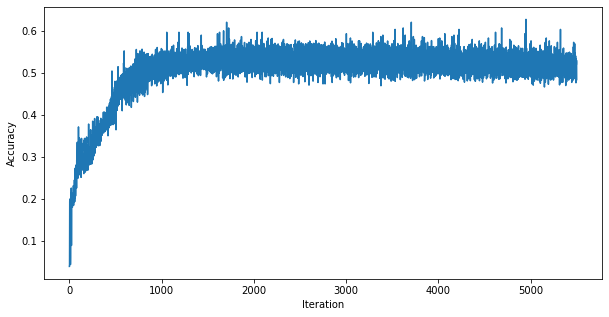

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

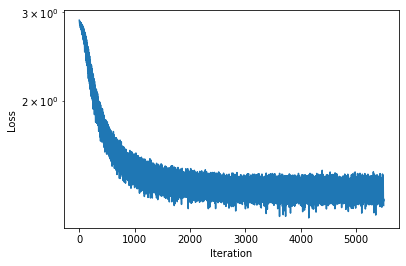

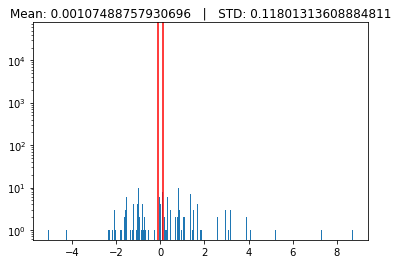

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 6.625


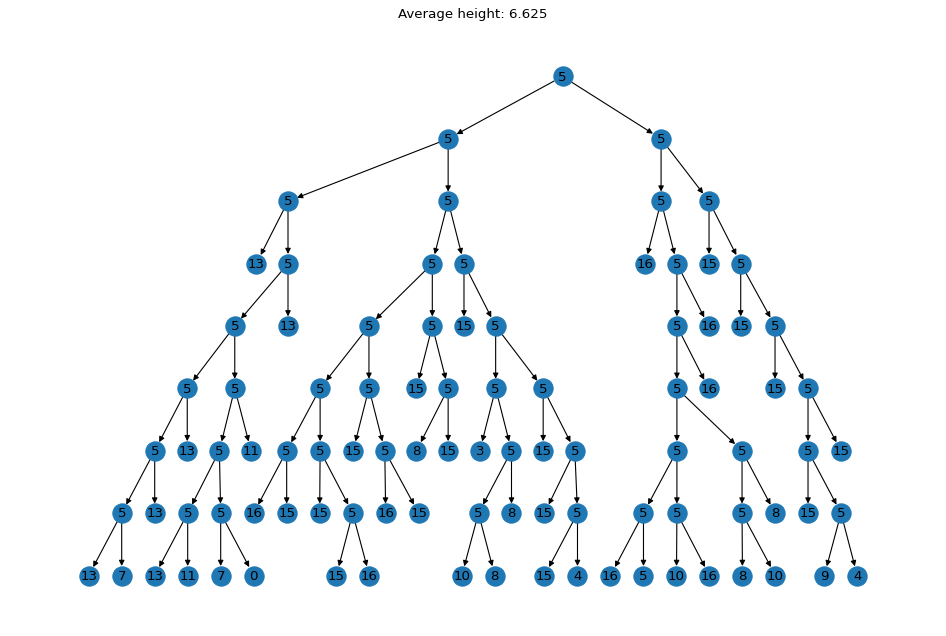

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [23]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 48


In [24]:
method = 'MLE'

In [25]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

# Tighten boundaries

In [26]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")

============== Pattern 1 ==============
1914
============== Pattern 2 ==============
============== Pattern 3 ==============
1672
============== Pattern 4 ==============
1002
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
6169
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
=====